# Explore the Data for Kaggle Parkinson's Prediction

https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from typing import Any, Dict, Union
from xgboost import XGBClassifier, XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tqdm import tqdm


# pd.set_option('display.max_rows', None)

In [171]:
train_clin_df = pd.read_csv('../data/raw/train_clinical_data.csv')
train_prot_df = pd.read_csv('../data/raw/train_proteins.csv')
train_pep_df = pd.read_csv('../data/raw/train_peptides.csv')

test_df = pd.read_csv('../data/raw/test.csv')
test_prot_df = pd.read_csv('../data/raw/test_proteins.csv')
test_pep_df = pd.read_csv('../data/raw/test_peptides.csv')

sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

In [172]:
updrs_1_kfolds = pd.read_csv('../data/processed/train_updrs_1.csv')
updrs_2_kfolds = pd.read_csv('../data/processed/train_updrs_2.csv')
updrs_3_kfolds = pd.read_csv('../data/processed/train_updrs_3.csv')
updrs_4_kfolds = pd.read_csv('../data/processed/train_updrs_4.csv')

### Check what the progression of the min and max UPDRs is like
Then look at if there are any proteins that are associated with the updrs that above the mean change

In [173]:
updrs_progression = train_clin_df.groupby(['patient_id'])['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'].max() - train_clin_df.groupby(['patient_id'])['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'].min()
updrs_progression.mean()

C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


updrs_1     8.076613
updrs_2     7.040323
updrs_3    17.665323
updrs_4     4.207650
dtype: float64

In [174]:
# classify the patients into 3 groups based on the updrs progression
updrs_progression['updrs_1'] = pd.qcut(updrs_progression['updrs_1'], 3, labels=['low', 'medium', 'high'])
updrs_progression['updrs_2'] = pd.qcut(updrs_progression['updrs_2'], 3, labels=['low', 'medium', 'high'])
updrs_progression['updrs_3'] = pd.qcut(updrs_progression['updrs_3'], 3, labels=['low', 'medium', 'high'])

In [175]:
cat_updrs_progression = updrs_progression[['updrs_1', 'updrs_2', 'updrs_3']]


In [176]:
train_prot_df.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [177]:
train_prot_pivot = train_prot_df.pivot(columns='UniProt', values='NPX', index=['patient_id', 'visit_month'])
train_protein_mean = train_prot_pivot.groupby(['patient_id']).mean()
train_protein_diff = train_prot_pivot.groupby(['patient_id']).max() - train_prot_pivot.groupby(['patient_id']).min()

In [178]:
cat_updrs_diff_plot = cat_updrs_progression.merge(train_protein_diff, on='patient_id')

In [179]:
cat_updrs_diff_updr1 = cat_updrs_diff_plot.drop(columns=['updrs_2', 'updrs_3'])
cat_updrs_diff_updr2 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_3'])
cat_updrs_diff_updr3 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_2'])

In [180]:
#replace high with 10, medium with 5 and low with 0
cat_updrs_diff_updr1 = cat_updrs_diff_updr1.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr2 = cat_updrs_diff_updr2.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr3 = cat_updrs_diff_updr3.replace({'high': 10, 'medium': 5, 'low': 0})

## Look for Correlations with the Protein Means and the UPDRs scores

In [181]:

# get the correlations between the updrs progression and the proteins
cat_updrs_diff_updr1.corr()['updrs_1'].sort_values(ascending=False)

updrs_1    1.000000
P61916     0.170089
P08697     0.168615
P20774     0.108141
P01861     0.105472
             ...   
Q9NYU2    -0.107754
P05156    -0.109881
Q9BY67    -0.131625
Q99829    -0.136988
P40925    -0.138551
Name: updrs_1, Length: 228, dtype: float64

In [182]:
train_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [183]:
train_pep_pivot = train_pep_df.pivot(columns='Peptide', values='PeptideAbundance', index=['patient_id', 'visit_month'])
train_pep_mean = train_pep_pivot.groupby(['patient_id']).mean()
train_pep_diff = train_pep_pivot.groupby(['patient_id']).max() - train_pep_pivot.groupby(['patient_id']).min()

In [184]:
cat_updrs_diff_plot = cat_updrs_progression.merge(train_pep_diff, on='patient_id')


cat_updrs_diff_updr1 = cat_updrs_diff_plot.drop(columns=['updrs_2', 'updrs_3'])
cat_updrs_diff_updr2 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_3'])
cat_updrs_diff_updr3 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_2'])

In [185]:
#replace high with 10, medium with 5 and low with 0
cat_updrs_diff_updr1 = cat_updrs_diff_updr1.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr2 = cat_updrs_diff_updr2.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr3 = cat_updrs_diff_updr3.replace({'high': 10, 'medium': 5, 'low': 0})

In [186]:
# get the correlations between the updrs progression and the proteins
cat_updrs_diff_updr3.corr()['updrs_3'].sort_values(ascending=False)

updrs_3                                                                1.000000
EPQVYTLPPSRDELTK                                                       0.281868
HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR                0.184300
QTHQPPAPNSLIR                                                          0.172443
KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK    0.165136
                                                                         ...   
LHDRNTYEKYLGEEYVK                                                     -0.159031
GSGGLNLGNFFASR                                                        -0.162529
SSQGGSLPSEEK                                                          -0.165821
AVISPGFDVFAK                                                          -0.187454
VAHQLQALR                                                             -0.213259
Name: updrs_3, Length: 969, dtype: float64

In [187]:
test_df.head()

,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0


In [188]:
test_prot_df.head()

,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [189]:
test_prot_df['visit_month'].value_counts()

0    227
6    226
Name: visit_month, dtype: int64

In [190]:
test_prot_df.groupby(['patient_id'])['visit_month'].unique()

patient_id
3342     [6]
50423    [0]
Name: visit_month, dtype: object

### Test Protein Data

There is only one visit month per patient in this test_df. As well, that visit month is not always 0. Something to be thoughtful of in creating the training set.

In [191]:
test_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [192]:
test_pep_df['visit_month'].value_counts()

6    1036
0    1021
Name: visit_month, dtype: int64

In [193]:
test_prot_df.groupby(['patient_id'])['visit_month'].unique()

patient_id
3342     [6]
50423    [0]
Name: visit_month, dtype: object

### Test Peptide Data

There is only one month per patient in the peptide data which corresponds with the protein data which makes sense.

In [194]:
sample_submission.shape

(64, 3)

In [195]:
sample_submission

,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6
60,50423_6_updrs_4_plus_0_months,0,6
61,50423_6_updrs_4_plus_6_months,0,6
62,50423_6_updrs_4_plus_12_months,0,6


### Description of the sample submission:
- prediction_id: the row id, updrs number, and the number of months later predicting
- rating: the prediction value of the updrs
- group_key: looks to be the last number of the row id, which is the visit month

#### The sample submission is requesting predictions on row id 3342_0 which does not have any protein data associated with it. That is very surprising.

## Training Data

In [196]:
train_clin_df.head(20)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [197]:
train_clin_df['upd23b_clinical_state_on_medication'].value_counts()

On     775
Off    513
Name: upd23b_clinical_state_on_medication, dtype: int64

In [198]:
train_clin_df['upd23b_clinical_state_on_medication'].isna().sum() / train_clin_df.shape[0]

0.5074569789674952

### Upd23b medication

There are 50% of the samples have NaN for the medication. This feature may be something to exclude.

In [199]:
train_clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].isna().sum() / train_clin_df.shape[0]

updrs_1    0.000382
updrs_2    0.000765
updrs_3    0.009560
updrs_4    0.396941
dtype: float64

### UPDRs NaN values

UPDRs 4 has 40% missing values.

- Can these values be imputed from anothe updrs that is highly correlated?

In [200]:
train_clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].corr()

,updrs_1,updrs_2,updrs_3,updrs_4
updrs_1,1.000000,0.661802,0.434569,0.432620
updrs_2,0.661802,1.000000,0.735106,0.383866
updrs_3,0.434569,0.735106,1.000000,0.221593
updrs_4,0.432620,0.383866,0.221593,1.000000


### No Major UPDR 4 correlation

Based on simple correlation there is no way to impute the missing values

## Value Distributions by UPDRs and Visit Month

In [201]:
def plot_month_v_updrs(updrs):
    updrs_1_df = train_clin_df.dropna(subset=[updrs])

    x = updrs_1_df['visit_month']
    y = updrs_1_df[updrs]

    slope, intercept = np.polyfit(x, y, 1)

    # Create scatter plot and regression line
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.plot(x, slope*x + intercept, color='red')

    plt.title(f'{updrs} Values by Visit Month')
    plt.xlabel('Visit Month')
    plt.ylabel(updrs)
    plt.show()

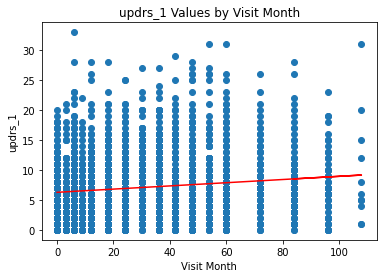

In [202]:
plot_month_v_updrs('updrs_1')

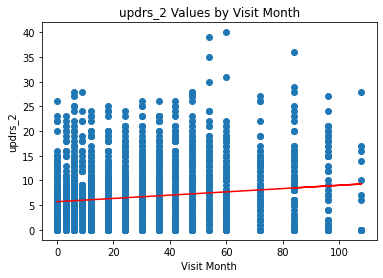

In [203]:
plot_month_v_updrs('updrs_2')

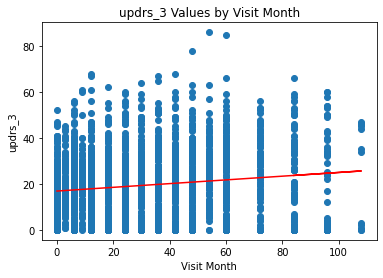

In [204]:
plot_month_v_updrs('updrs_3')

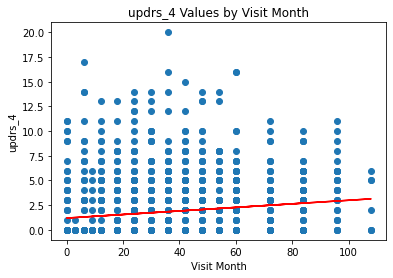

In [205]:
plot_month_v_updrs('updrs_4')

### There is no clear linear pattern for the visit month and the UPDRS

## View the Change in UPDRS values over the visit months

In [206]:
# get the min visit month for each patient
min_visit_month = train_clin_df.groupby(['patient_id'])['visit_month'].min().reset_index()

print(f'There', min_visit_month[min_visit_month['visit_month'] != 0].shape[0], 'patients with a min visit month other than 0')

# create a dictionary of the first visit values for each updrs
min_visit_dict = train_clin_df[train_clin_df['visit_month'] == 0][['patient_id','updrs_1', 'updrs_2','updrs_3', 'updrs_4']]\
                                    .set_index(['patient_id'])\
                                    .to_dict(orient='dict')


There 0 patients with a min visit month other than 0


In [207]:

# loop through the rows and get the change in updrs value from the first visit for every visit of a patient
for i, row in train_clin_df.iterrows():
    patient_id = row['patient_id']
    for updrs in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
        train_clin_df.loc[i, f'{updrs}_change'] = row[updrs] - min_visit_dict[updrs][patient_id]
        

## plot the change of values over visit_month

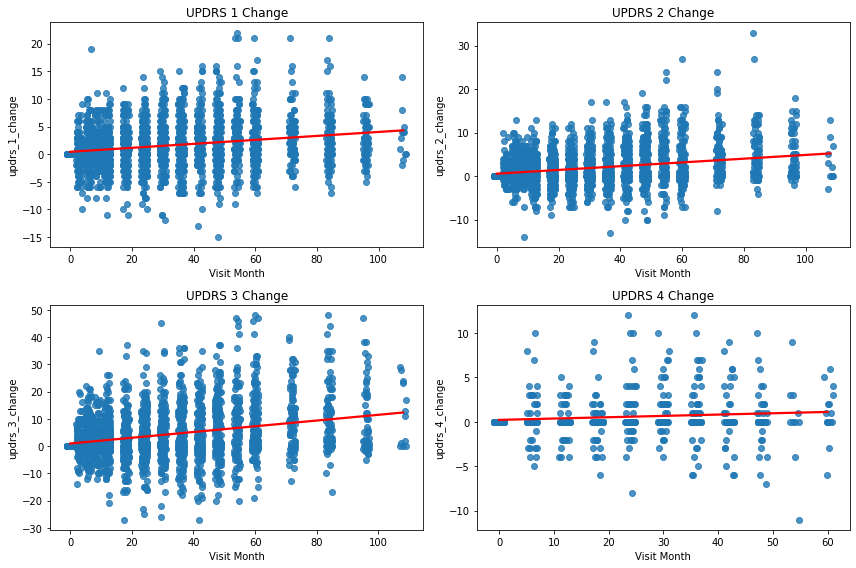

In [208]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Define the column names and corresponding subplot titles
columns = ['updrs_1_change', 'updrs_2_change', 'updrs_3_change', 'updrs_4_change']
titles = ['UPDRS 1 Change', 'UPDRS 2 Change', 'UPDRS 3 Change', 'UPDRS 4 Change']

# Plotting subplots
for i, column in enumerate(columns):
    ax = axes[i]
    sns.regplot(data=train_clin_df, x='visit_month', y=column, ax=ax, scatter=True, ci=None, x_jitter=True, line_kws={'color':'red'})
    ax.set_title(titles[i])
    ax.set_xlabel('Visit Month')
    ax.set_ylabel(column)

# Adjust the layout and spacing
plt.tight_layout()

# Display the plot
plt.show()

### The change in UPDRS by visit month is a bit more linear in nature

## Classify the Patients Based on their First and their Last Visit Value Change

In [209]:
def get_quantiles(updrs):

    df = train_clin_df.dropna(subset=[updrs])

    # Order the DataFrame by visit_month ascending and patient_id
    df = df.sort_values(by=['visit_month', 'patient_id'])

    # Get the first and last values of updrs_1 for each patient_id
    first_last_updrs = df.groupby('patient_id')[updrs].agg(['first', 'last']).reset_index()
    first_last_months = df.groupby('patient_id')['visit_month'].agg(['first', 'last']).reset_index()
    first_last_updrs = first_last_updrs.rename(columns={'last':'last_updrs', 'first':'first_updrs'})
    first_last_months = first_last_months.rename(columns={'last':'last_months', 'first':'first_months'})
    first_last_updrs['updrs_diff'] = first_last_updrs['last_updrs'] - first_last_updrs['first_updrs']
    first_last_months['months_diff'] = first_last_months['last_months'] - first_last_months['first_months']
    
    
    first_last_updrs = first_last_updrs.merge(first_last_months, how='left', left_on='patient_id', right_on='patient_id')
    
    # divide the updr_diff by the month_diff to get average change per month
    first_last_updrs['avg_monthly_diff'] = first_last_updrs['updrs_diff'] / first_last_updrs['months_diff']
    
    quantiles  = first_last_updrs['avg_monthly_diff'].quantile([0.33, 0.66])
    
    print(f'The mean change between the quantiles for {updrs} is {quantiles[0.33]} and {quantiles[0.66]}')
    
    return quantiles, first_last_updrs

In [210]:
updrs_1_q, first_last_updrs_1 = get_quantiles('updrs_1')

The mean change between the quantiles for updrs_1 is 0.0 and 0.05555555555555555


In [211]:
updrs_2_q, first_last_updrs_2 = get_quantiles('updrs_2')

The mean change between the quantiles for updrs_2 is 0.0 and 0.07142857142857142


In [212]:
updrs_3_q, first_last_updrs_3 = get_quantiles('updrs_3')

The mean change between the quantiles for updrs_3 is 0.0 and 0.14285714285714285


In [213]:
updrs_4_q, first_last_updrs_4 = get_quantiles('updrs_4')

The mean change between the quantiles for updrs_4 is 0.0 and 0.03932549019607843


In [214]:
def updrs_1_cats(val):
    if val <= updrs_1_q[0.66]:
        return 0
    return 1

def updrs_2_cats(val):
    if val <= updrs_2_q[0.66]:
        return 0
    return 1

def updrs_3_cats(val):
    if val <= updrs_3_q[0.66]:
        return 0
    return 1

def updrs_4_cats(val):
    if val <= updrs_4_q[0.66]:
        return 0
    return 1

In [215]:
first_last_updrs_1['updrs_1_large_diff'] = first_last_updrs_1['avg_monthly_diff'].apply(updrs_1_cats)

In [216]:
first_last_updrs_2['updrs_2_large_diff'] = first_last_updrs_2['avg_monthly_diff'].apply(updrs_2_cats)

In [217]:
first_last_updrs_3['updrs_3_large_diff'] = first_last_updrs_3['avg_monthly_diff'].apply(updrs_3_cats)

In [218]:
first_last_updrs_4['updrs_4_large_diff'] = first_last_updrs_4['avg_monthly_diff'].apply(updrs_4_cats)

In [219]:
first_last_updrs_1

,patient_id,first_updrs,last_updrs,updrs_diff,first_months,last_months,months_diff,avg_monthly_diff,updrs_1_large_diff
0,55,10.0,23.0,13.0,0,60,60,0.216667,1
1,942,3.0,6.0,3.0,0,96,96,0.031250,0
2,1517,11.0,19.0,8.0,0,60,60,0.133333,1
3,1923,2.0,3.0,1.0,0,36,36,0.027778,0
4,2660,2.0,5.0,3.0,0,60,60,0.050000,0
...,...,...,...,...,...,...,...,...,...
243,63875,3.0,3.0,0.0,0,48,48,0.000000,0
244,63889,7.0,6.0,-1.0,0,60,60,-0.016667,0
245,64669,12.0,16.0,4.0,0,84,84,0.047619,0
246,64674,5.0,10.0,5.0,0,96,96,0.052083,0


In [220]:
# combine the large_difference categorization with the train_clin_df data
train_clin_df = first_last_updrs_1[['updrs_1_large_diff', 'patient_id']].merge(train_clin_df, on='patient_id')
train_clin_df = first_last_updrs_2[['updrs_2_large_diff', 'patient_id']].merge(train_clin_df, on='patient_id')
train_clin_df = first_last_updrs_3[['updrs_3_large_diff', 'patient_id']].merge(train_clin_df, on='patient_id')
train_clin_df = first_last_updrs_4[['updrs_4_large_diff', 'patient_id']].merge(train_clin_df, on='patient_id')

train_clin_df.head(20)

,updrs_4_large_diff,patient_id,updrs_3_large_diff,updrs_2_large_diff,updrs_1_large_diff,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_1_change,updrs_2_change,updrs_3_change,updrs_4_change
0,0,55,1,1,1,55_0,0,10.0,6.0,15.0,NaN,NaN,0.0,0.0,0.0,NaN
1,0,55,1,1,1,55_3,3,10.0,7.0,25.0,NaN,NaN,0.0,1.0,10.0,NaN
2,0,55,1,1,1,55_6,6,8.0,10.0,34.0,NaN,NaN,-2.0,4.0,19.0,NaN
3,0,55,1,1,1,55_9,9,8.0,9.0,30.0,0.0,On,-2.0,3.0,15.0,NaN
4,0,55,1,1,1,55_12,12,10.0,10.0,41.0,0.0,On,0.0,4.0,26.0,NaN
5,0,55,1,1,1,55_18,18,7.0,13.0,38.0,0.0,On,-3.0,7.0,23.0,NaN
6,0,55,1,1,1,55_24,24,16.0,9.0,49.0,0.0,On,6.0,3.0,34.0,NaN
7,0,55,1,1,1,55_30,30,14.0,13.0,49.0,0.0,On,4.0,7.0,34.0,NaN
8,0,55,1,1,1,55_36,36,17.0,18.0,51.0,0.0,On,7.0,12.0,36.0,NaN
9,0,55,1,1,1,55_42,42,12.0,20.0,41.0,0.0,On,2.0,14.0,26.0,NaN


## Plot the UPDRS Change vs Month and color by large or small change Categorical label

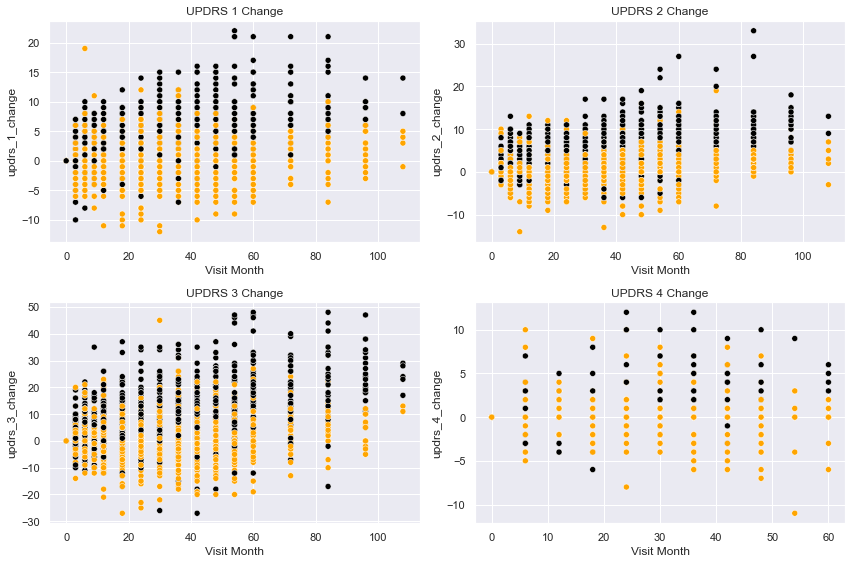

In [231]:
sns.set(style='darkgrid')

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Define the column names and corresponding subplot titles
columns = ['updrs_1_change', 'updrs_2_change', 'updrs_3_change', 'updrs_4_change']
titles = ['UPDRS 1 Change', 'UPDRS 2 Change', 'UPDRS 3 Change', 'UPDRS 4 Change']
large_diff = ['updrs_1_large_diff', 'updrs_2_large_diff', 'updrs_3_large_diff','updrs_4_large_diff']
color_map = {0:'orange', 1:'black'}


# Plotting subplots
for i, column in enumerate(columns):
    ax = axes[i]
    sns.scatterplot(data=train_clin_df, x='visit_month', y=column, hue=large_diff[i],
                    ax=ax, palette=color_map, legend=False)
    #sns.regplot(data=train_clin_df, x='visit_month', y=column, ax=ax, scatter=False, ci=None, color='maroon')
    ax.set_title(titles[i])
    ax.set_xlabel('Visit Month')
    ax.set_ylabel(column)

# Adjust the layout and spacing
plt.tight_layout()

# Display the plot
plt.show()

## Plot the UPDRS vs Month and color by large change or small change Categorical label

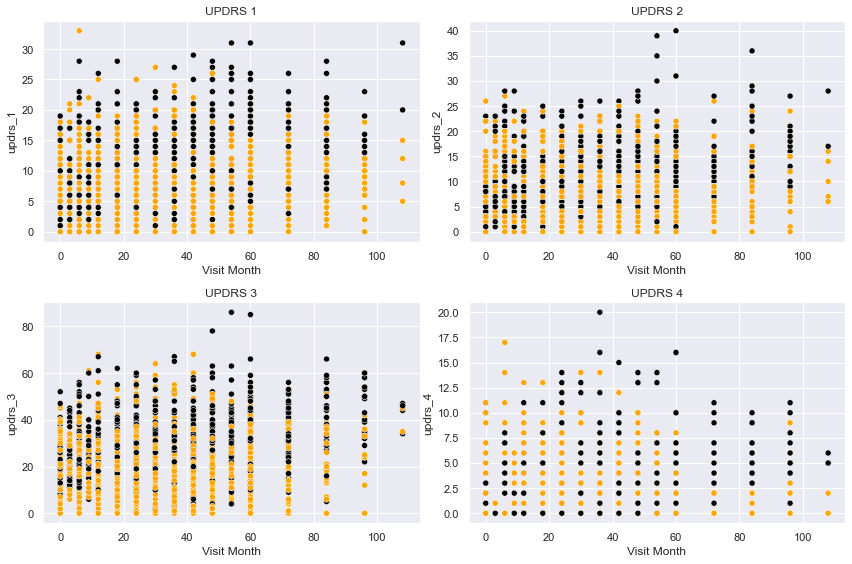

In [234]:
sns.set(style='darkgrid')

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Define the column names and corresponding subplot titles
columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
titles = ['UPDRS 1', 'UPDRS 2', 'UPDRS 3', 'UPDRS 4']
large_diff = ['updrs_1_large_diff', 'updrs_2_large_diff', 'updrs_3_large_diff','updrs_4_large_diff']
color_map = {0:'orange', 1:'black'}


# Plotting subplots
for i, column in enumerate(columns):
    ax = axes[i]
    sns.scatterplot(data=train_clin_df, x='visit_month', y=column, hue=large_diff[i],
                    ax=ax, palette=color_map, legend=False)
    #sns.regplot(data=train_clin_df, x='visit_month', y=column, ax=ax, scatter=False, ci=None, color='maroon')
    ax.set_title(titles[i])
    ax.set_xlabel('Visit Month')
    ax.set_ylabel(column)

# Adjust the layout and spacing
plt.tight_layout()

# Display the plot
plt.show()

### This shows that the UPDRS can start high and stay high or they can start low and end high. There is less of a pattern when looking at the UPDRS raw values over time, but looking at the UPDRS change over time shows some good separation patterns.

## Get the Average Ending UPDRS value

In [161]:
def get_avg_last(updrs):

    df = train_clin_df.dropna(subset=[updrs])

    # Order the DataFrame by visit_month ascending and patient_id
    df = df.sort_values(by=['visit_month', 'patient_id'])

    # Get the first and last values of updrs_1 for each patient_id
    first_last_updrs = df.groupby('patient_id')[updrs].agg(['first', 'last']).reset_index()

    last_values  = first_last_updrs['last'].quantile([0.33, 0.66])

    print(f'The quantiles of last {updrs} is {last_values[0.33]} and {last_values[0.66]}')

    return last_values, first_last_updrs

In [162]:
updrs_1_last, median_last_updrs_1 = get_avg_last('updrs_1')
updrs_2_last, median_last_updrs_2 = get_avg_last('updrs_2')
updrs_3_last, median_last_updrs_3 = get_avg_last('updrs_3')
updrs_4_last, median_last_updrs_4 = get_avg_last('updrs_4')

The quantiles of last updrs_1 is 5.0 and 10.0
The quantiles of last updrs_2 is 2.0 and 11.0
The quantiles of last updrs_3 is 6.0 and 28.02000000000001
The quantiles of last updrs_4 is 0.0 and 3.0


In [163]:
def updrs_1_last_cat(val):
    if val <= updrs_1_last[0.66]:
        return 0
    return 1

def updrs_2_last_cat(val):
    if val <= updrs_2_last[0.66]:
        return 0
    return 1

def updrs_3_last_cat(val):
    if val <= updrs_3_last[0.66]:
        return 0
    return 1

def updrs_4_last_cat(val):
    if val <= updrs_4_last[0.66]:
        return 0
    return 1

In [164]:
median_last_updrs_1['updrs_1_large_last_val'] = median_last_updrs_1['last'].apply(updrs_1_last_cat)
median_last_updrs_2['updrs_2_large_last_val'] = median_last_updrs_2['last'].apply(updrs_2_last_cat)
median_last_updrs_3['updrs_3_large_last_val'] = median_last_updrs_3['last'].apply(updrs_3_last_cat)
median_last_updrs_4['updrs_4_large_last_val'] = median_last_updrs_4['last'].apply(updrs_4_last_cat)


In [165]:
categorical_updrs_1 = median_last_updrs_1.merge(first_last_updrs_1[['patient_id', 'updrs_1_large_diff']], how='left', on='patient_id')
categorical_updrs_2 = median_last_updrs_2.merge(first_last_updrs_2[['patient_id', 'updrs_2_large_diff']], how='left', on='patient_id')
categorical_updrs_3 = median_last_updrs_3.merge(first_last_updrs_3[['patient_id', 'updrs_3_large_diff']], how='left', on='patient_id')
categorical_updrs_4 = median_last_updrs_4.merge(first_last_updrs_4[['patient_id', 'updrs_4_large_diff']], how='left', on='patient_id')


# Use Feature Selection for the Categorical Values

In [117]:
train_updrs_1 = pd.read_csv('../data/processed/train_updrs_1.csv')
train_updrs_2 = pd.read_csv('../data/processed/train_updrs_2.csv')
train_updrs_3 = pd.read_csv('../data/processed/train_updrs_3.csv')
train_updrs_4 = pd.read_csv('../data/processed/train_updrs_4.csv')

### Use Cross Correlation to Remove Features

In [53]:
def find_high_correlations(df):
    corr_matrix = df.corr(method='spearman')
    high_correlations = []
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 == col2:
                continue
            if corr_matrix.loc[col1, col2] >= 0.75:
                high_correlations.append((col1, col2))
    return high_correlations

In [63]:
df = train_updrs_1

# get only the protein columns
protein_cols = df.drop(columns=['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'kfold']).columns

# get the correlations above 0.75
high_corr = find_high_correlations(df[protein_cols])
print(len(high_corr))

corr_df = df[protein_cols].corr(method='spearman')
corr_df['mean'] = corr_df.mean()
mean_corr_dict = corr_df['mean'].to_dict()

for tup in high_corr[:400]:
    try:
        if tup[0] in mean_corr_dict.keys() and tup[1] in mean_corr_dict.keys():
            tup_0_corr = mean_corr_dict[tup[0]]
            tup_1_corr = mean_corr_dict[tup[1]]
        
            if tup_0_corr > tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
            if tup_0_corr < tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[1], 'mean']]
                print(f'Removed: {tup[1]}')
            else:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
        
            corr_df = df[corr_df_cols].corr(method='spearman')
            high_corr = find_high_correlations(df[corr_df_cols])
            corr_df['mean'] = corr_df.mean()
            print('Shape of Corr DF:', corr_df.shape[0])
            mean_corr_dict = corr_df['mean'].to_dict()
    except:
        continue
    
    print(len(high_corr))
    


4240
Removed: O00391
Shape of Corr DF: 1194
4238
Removed: O00533
Removed: O00533
Shape of Corr DF: 1193
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
4110
Removed: O00584
Removed: O00584
Shape of Corr DF: 1192
4106
4106
Removed: O14498
Shape of Corr DF: 1191
4104
Removed: O14773
Removed: O14773
Shape of Corr DF: 1190
4102
Removed: O14791
Shape of Corr DF: 1189
4100
4100
Removed: P05067
Shape of Corr DF: 1188
4030
Removed: P10645
Shape of Corr DF: 1187
3920
Removed: P13521
Shape of Corr DF: 1186
3856
Removed: O15240
Removed: O15240
Shape of Corr DF: 1185
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
Removed: O15394
Removed: O15394
Shape of Corr DF: 1184
3810
3810
3

In [64]:
corr_df = df[corr_df_cols].corr(method='spearman')
high_corr = find_high_correlations(df[corr_df_cols])
corr_df['mean'] = corr_df.mean()
print('Shape of Corr DF:', corr_df.shape[0])
mean_corr_dict = corr_df['mean'].to_dict()

for tup in high_corr[:400]:
    try:
        if tup[0] in mean_corr_dict.keys() and tup[1] in mean_corr_dict.keys():
            tup_0_corr = mean_corr_dict[tup[0]]
            tup_1_corr = mean_corr_dict[tup[1]]
        
            if tup_0_corr > tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
            if tup_0_corr < tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[1], 'mean']]
                print(f'Removed: {tup[1]}')
            else:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
        
            corr_df = df[corr_df_cols].corr(method='spearman')
            high_corr = find_high_correlations(df[corr_df_cols])
            corr_df['mean'] = corr_df.mean()
            print('Shape of Corr DF:', corr_df.shape[0])
            mean_corr_dict = corr_df['mean'].to_dict()
    except:
        continue
    
    print(len(high_corr))

Shape of Corr DF: 1100
Removed: FEHC(UniMod_4)NFNDVTTR_P13987
Shape of Corr DF: 1099
2680
Removed: P04156
Shape of Corr DF: 1098
2678
Removed: P04180
Removed: P04180
Shape of Corr DF: 1097
2674
2674
Removed: HPNVFGFC(UniMod_4)R_P04196
Shape of Corr DF: 1096
2670
Removed: VSPTDC(UniMod_4)SAVEPEAEK_P04196
Shape of Corr DF: 1095
2668
Removed: P04207
Shape of Corr DF: 1094
2666
Removed: P04211
Shape of Corr DF: 1093
2664
Removed: ATWSGAVLAGR_P04217
Shape of Corr DF: 1092
2658
Removed: LLELTGPK_P04217
Shape of Corr DF: 1091
2656
Removed: P04217
Removed: P04217
Shape of Corr DF: 1090
2654
Removed: P04275
Shape of Corr DF: 1089
2652
Removed: P04406
Shape of Corr DF: 1088
2650
Removed: P04433
Removed: P04433
Shape of Corr DF: 1087
2646
2646
Removed: GEAGAPGEEDIQGPTK_P05060
Shape of Corr DF: 1086
2632
Removed: P05060
Removed: P05060
Shape of Corr DF: 1085
2628
2628
Removed: P05090
Removed: P05090
Shape of Corr DF: 1084
2622
2622
2622
Removed: P05155
Removed: P05155
Shape of Corr DF: 1083
2620
R

Shape of Corr DF: 965
1722
1722
Removed: IC(UniMod_4)LEDNVLMSGVK_Q92520
Shape of Corr DF: 964
1706
Removed: MDASLGNLFAR_Q92520
Shape of Corr DF: 963
1692
Removed: SMEQNGPGLEYR_O00533
Shape of Corr DF: 962
1618
Removed: SPQGLGAFTPVVR_Q13332
Shape of Corr DF: 961
1602
Removed: TALASGGVLDASGDYR_O43505
Shape of Corr DF: 960
1580
Removed: VNGSPVDNHPFAGDVVFPR_O00533
Shape of Corr DF: 959
1544
Removed: Q7Z3B1
Shape of Corr DF: 958
1538
1538
1538
Removed: Q7Z5P9
Shape of Corr DF: 957
1536
Removed: Q8IWV7
Shape of Corr DF: 956
1534
Removed: Q8N2S1
Shape of Corr DF: 955
1532
1532
1532
1532
1532
1532
1532
1532
1532
1532
1532
1532
1532
1532
1532
1532
Removed: Q8NE71
Shape of Corr DF: 954
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528
1528


In [65]:
mid_corr_df = corr_df.copy(deep=True)
mid_corr_list = high_corr

In [66]:
corr_df = df[corr_df_cols].corr(method='spearman')
high_corr = find_high_correlations(df[corr_df_cols])
corr_df['mean'] = corr_df.mean()
print('Shape of Corr DF:', corr_df.shape[0])
mean_corr_dict = corr_df['mean'].to_dict()

for tup in high_corr[:400]:
    try:
        if tup[0] in mean_corr_dict.keys() and tup[1] in mean_corr_dict.keys():
            tup_0_corr = mean_corr_dict[tup[0]]
            tup_1_corr = mean_corr_dict[tup[1]]
        
            if tup_0_corr > tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
            if tup_0_corr < tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[1], 'mean']]
                print(f'Removed: {tup[1]}')
            else:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
        
            corr_df = df[corr_df_cols].corr(method='spearman')
            high_corr = find_high_correlations(df[corr_df_cols])
            corr_df['mean'] = corr_df.mean()
            print('Shape of Corr DF:', corr_df.shape[0])
            mean_corr_dict = corr_df['mean'].to_dict()
    except:
        continue
    
    print(len(high_corr))

Shape of Corr DF: 954
Removed: Q92876
Removed: Q92876
Shape of Corr DF: 953
1524
1524
Removed: Q96BZ4
Shape of Corr DF: 952
1522
Removed: Q96KN2
Removed: Q96KN2
Shape of Corr DF: 951
1514
1514
1514
1514
Removed: Q96PD5
Removed: Q96PD5
Shape of Corr DF: 950
1510
1510
Removed: Q96S96
Shape of Corr DF: 949
1508
Removed: Q99435
Shape of Corr DF: 948
1506
Removed: Q99674
Shape of Corr DF: 947
1500
1500
1500
Removed: Q99683
Shape of Corr DF: 946
1498
Removed: Q99829
Shape of Corr DF: 945
1496
Removed: Q99832
Shape of Corr DF: 944
1494
Removed: Q99969
Shape of Corr DF: 943
1492
Removed: Q9BY67
Shape of Corr DF: 942
1490
Removed: Q9HDC9
Shape of Corr DF: 941
1488
Removed: GVALADFNR_Q9NQ79
Shape of Corr DF: 940
1466
Removed: Q9NQ79
Removed: Q9NQ79
Shape of Corr DF: 939
1464
Removed: Q9NYU2
Shape of Corr DF: 938
1462
Removed: Q9UBR2
Shape of Corr DF: 937
1460
Removed: Q9UBX5
Removed: Q9UBX5
Shape of Corr DF: 936
1458
Removed: Q9UHG2
Removed: Q9UHG2
Shape of Corr DF: 935
1440
1440
1440
1440
1440


Shape of Corr DF: 854
766
766
766
766
766
766
766
766
766
Removed: FDEFFSEGC(UniMod_4)APGSK_P02787
Shape of Corr DF: 853
750
Removed: HSTIFENLANK_P02787
Shape of Corr DF: 852
746
Removed: KC(UniMod_4)STSSLLEAC(UniMod_4)TFR_P02787
Shape of Corr DF: 851
738
Removed: LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNK_P02787
Shape of Corr DF: 850
734
Removed: LKC(UniMod_4)DEWSVNSVGK_P02787
Shape of Corr DF: 849
730
Removed: EGYYGYTGAFR_P02787
Removed: EGYYGYTGAFR_P02787
Shape of Corr DF: 848
724
724
724
Removed: EIQNAVNGVK_P10909
Removed: EIQNAVNGVK_P10909
Shape of Corr DF: 847
712
712
712
712
712
712
Removed: VKSPELQAEAK_P02652
Shape of Corr DF: 846
710
Removed: EQWPQC(UniMod_4)PTIK_P07858
Removed: EQWPQC(UniMod_4)PTIK_P07858
Shape of Corr DF: 845
708
708
708
708
708
708
708
708
708
708
Removed: FAALDNEEEDK_Q8NE71
Removed: FAALDNEEEDK_Q8NE71
Shape of Corr DF: 844
706
706
706
706
706
706
706
706
706
706
706
706
Removed: VFNTPEGVPSAPSSLK_Q92823
Shape of Corr DF: 843
686
Removed: YGQTIRPIC(UniMod_4)LPC(Uni

In [67]:
corr_df = df[corr_df_cols].corr(method='spearman')
high_corr = find_high_correlations(df[corr_df_cols])
corr_df['mean'] = corr_df.mean()
print('Shape of Corr DF:', corr_df.shape[0])
mean_corr_dict = corr_df['mean'].to_dict()

for tup in high_corr[:400]:
    try:
        if tup[0] in mean_corr_dict.keys() and tup[1] in mean_corr_dict.keys():
            tup_0_corr = mean_corr_dict[tup[0]]
            tup_1_corr = mean_corr_dict[tup[1]]
        
            if tup_0_corr > tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
            if tup_0_corr < tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[1], 'mean']]
                print(f'Removed: {tup[1]}')
            else:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
        
            corr_df = df[corr_df_cols].corr(method='spearman')
            high_corr = find_high_correlations(df[corr_df_cols])
            corr_df['mean'] = corr_df.mean()
            print('Shape of Corr DF:', corr_df.shape[0])
            mean_corr_dict = corr_df['mean'].to_dict()
    except:
        continue
    
    print(len(high_corr))

Shape of Corr DF: 833
Removed: KGGETSEMYLIQPDSSVKPYR_P02675
Shape of Corr DF: 832
540
540
Removed: MELERPGGNEITR_P02671
Shape of Corr DF: 831
532
Removed: NSLFEYQK_P02671
Shape of Corr DF: 830
524
Removed: QDGSVDFGR_P02675
Shape of Corr DF: 829
520
Removed: GGSTSYGTGSETESPR_P02671
Removed: GGSTSYGTGSETESPR_P02671
Shape of Corr DF: 828
518
Removed: GLVSWGNIPC(UniMod_4)GSK_Q92876
Removed: GLVSWGNIPC(UniMod_4)GSK_Q92876
Shape of Corr DF: 827
516
Removed: HVLFGTVGVPEHTYR_P04216
Shape of Corr DF: 826
496
Removed: GNPEPTFSWTK_O00533
Removed: GNPEPTFSWTK_O00533
Shape of Corr DF: 825
490
490
490
Removed: NWGLGGHAFC(UniMod_4)R_P00748
Shape of Corr DF: 824
488
Removed: TFYEPGEEITYSC(UniMod_4)KPGYVSR_P02749
Shape of Corr DF: 823
484
Removed: SPAINVAVHVFR_P02766
Shape of Corr DF: 822
482
Removed: HTFMGVVSLGSPSGEVSHPR_P02765
Shape of Corr DF: 821
478
Removed: GSPSGEVSHPR_P02765
Removed: GSPSGEVSHPR_P02765
Shape of Corr DF: 820
476
Removed: SNSSMHITDC(UniMod_4)R_P07998
Shape of Corr DF: 819
454
Remo

In [72]:
for tup in high_corr[:]:
    try:
        if tup[0] in mean_corr_dict.keys() and tup[1] in mean_corr_dict.keys():
            tup_0_corr = mean_corr_dict[tup[0]]
            tup_1_corr = mean_corr_dict[tup[1]]
        
            if tup_0_corr > tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
            if tup_0_corr < tup_1_corr:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[1], 'mean']]
                print(f'Removed: {tup[1]}')
            else:
                corr_df_cols = [prot for prot in corr_df.columns if prot not in  [tup[0], 'mean']]
                print(f'Removed: {tup[0]}')
        
            corr_df = df[corr_df_cols].corr(method='spearman')
            high_corr = find_high_correlations(df[corr_df_cols])
            corr_df['mean'] = corr_df.mean()
            print('Shape of Corr DF:', corr_df.shape[0])
            mean_corr_dict = corr_df['mean'].to_dict()
    except:
        continue
    
    print(len(high_corr))

Removed: TMQENSTPRED_P09871
Shape of Corr DF: 738
32
32
Removed: VPFDAATLHTSTAMAAQHGMDDDGTGQK_P06396
Shape of Corr DF: 737
30
Removed: VLDLSC(UniMod_4)NR_P08571
Shape of Corr DF: 736
28
Removed: VLSIAQAHSPAFSC(UniMod_4)EQVR_P08571
Shape of Corr DF: 735
26
Removed: YLFLNGNK_P02750
Shape of Corr DF: 734
24
Removed: VGYVSGWGR_P00738
Shape of Corr DF: 733
16
Removed: VMPIC(UniMod_4)LPSKDYAEVGR_P00738
Shape of Corr DF: 732
10
Removed: VTSIQDWVQK_P00738
Shape of Corr DF: 731
6
Removed: YVMLPVADQDQC(UniMod_4)IR_P00738
Shape of Corr DF: 730
4
Removed: VEHSDLSFSK_P61769
Removed: VEHSDLSFSK_P61769
Shape of Corr DF: 729
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
Removed: VVVNFAPTIQEIK_Q7Z3B1
Removed: VVVNFAPTIQEIK_Q7Z3B1
Shape of Corr DF: 728
0
0
0
0
0
0
0


In [76]:
corr_df.to_csv('low_corr_df.csv')
with open('filtered_cols.txt', 'w') as file:
    for val in corr_df_cols:
        file.write(str(val))
        file.write('\n')

In [79]:
filtered_corrs = train_updrs_1[corr_df_cols].corr()


In [87]:
last_high_corrs = []

for col in filtered_corrs.columns:
    temp_corrs = filtered_corrs[col].drop(col)
    if temp_corrs.max() > 0.75:
        last_high_corrs.append(col)
    if temp_corrs.min() < -0.75:
        last_high_corrs.append(col)

In [91]:
final_high_corrs = find_high_correlations(filtered_corrs[last_high_corrs])

In [92]:
for val in final_high_corrs:
    print(val[0])
    print(mean_corr_dict[val[0]])
    print(val[1])
    print(mean_corr_dict[val[1]])
    print('\n')

GSPAINVAVHVFRK_P02766
0.06633419745170925
GSPAINVAVHVFR_P02766
0.060045766468986704


GSPAINVAVHVFR_P02766
0.060045766468986704
GSPAINVAVHVFRK_P02766
0.06633419745170925


KLC(UniMod_4)MAALK_P02774
0.16375575722167693
RVWELSK_P01008
0.1386322352374153


LRTEGDGVYTLNNEK_P00738
0.06744808923331093
VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR_P00738
0.06228707047613917


LYGSEAFATDFQDSAAAK_P01011
0.10089864952372805
RLYGSEAFATDFQDSAAAK_P01011
0.10078581849709625


RLYGSEAFATDFQDSAAAK_P01011
0.10078581849709625
LYGSEAFATDFQDSAAAK_P01011
0.10089864952372805


RVWELSK_P01008
0.1386322352374153
KLC(UniMod_4)MAALK_P02774
0.16375575722167693


VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR_P00738
0.06228707047613917
LRTEGDGVYTLNNEK_P00738
0.06744808923331093




In [94]:
last_to_drop = ['GSPAINVAVHVFRK_P02766', 'KLC(UniMod_4)MAALK_P02774', 'LRTEGDGVYTLNNEK_P00738', 'LYGSEAFATDFQDSAAAK_P01011']

In [95]:
corr_df_cols = [col for col in corr_df_cols if col not in last_to_drop]
train_updrs_1[corr_df_cols].head()

,P04196,P08697,Q12841,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K_Q08380,AAFTEC(UniMod_4)C(UniMod_4)QAADK_P02768,AANEVSSADVK_Q13449,AATGEC(UniMod_4)TATVGKR_P01042,AATVGSLAGQPLQER_P02649,AAVYHHFISDGVR_P01024,ADDKETC(UniMod_4)FAEEGKK_P02768,...,YQC(UniMod_4)YC(UniMod_4)YGR_P02751,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,162567.0,166329.0,21065.0,44935.3,5991960.0,43182.9,15587.70,22459.20,40419.4,5506990.0,...,4792.26,223749.0,8239.62,3261690.0,175652.00,61756.0,120733.0,471637.0,34750.8,13215.8
1,209683.0,294864.0,14799.6,51984.8,5379790.0,14410.6,7968.41,65881.00,30199.8,2718270.0,...,4834.09,271632.0,7396.24,4937200.0,9970.55,75484.3,98472.8,326149.0,32177.8,27313.8
2,210301.0,95758.2,17058.0,45029.9,9200590.0,17428.0,14507.10,66026.40,33729.0,3942900.0,...,6167.84,223785.0,7813.67,5102610.0,49680.00,99610.6,182655.0,420676.0,40307.4,18854.4
3,230788.0,243370.0,35079.9,64866.1,10944500.0,36927.4,17470.20,0.00,65949.4,6396030.0,...,10507.50,205335.0,13707.10,5135370.0,30509.10,112250.0,198959.0,517531.0,47780.1,13218.4
4,234183.0,298456.0,18187.8,33483.9,7614550.0,14462.2,14305.10,2040.07,47365.7,3551600.0,...,3823.63,164216.0,3987.46,4570130.0,69358.80,45884.6,103051.0,735200.0,61510.1,22546.5


In [96]:
train_updrs_1[corr_df_cols].to_csv('low_corr_df.csv')
with open('filtered_cols.txt', 'w') as file:
    for val in corr_df_cols:
        file.write(str(val))
        file.write('\n')

## Transform the Uncorrelated Features

In [118]:
uncorr_updrs_1 = train_updrs_1[corr_df_cols]
uncorr_updrs_2 = train_updrs_2[corr_df_cols]
uncorr_updrs_3 = train_updrs_3[corr_df_cols]
uncorr_updrs_4 = train_updrs_4[corr_df_cols]

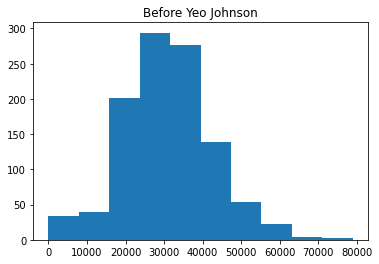

In [119]:
plt.hist(uncorr_updrs_1.iloc[:, 110])
plt.title("Before Yeo Johnson")
plt.show()

In [120]:
# transform the data
power_trans  = PowerTransformer(method='yeo-johnson', standardize=True)

uncorr_updrs_1[corr_df_cols] = power_trans.fit_transform(uncorr_updrs_1)
uncorr_updrs_2[corr_df_cols] = power_trans.fit_transform(uncorr_updrs_2)
uncorr_updrs_3[corr_df_cols] = power_trans.fit_transform(uncorr_updrs_3)
uncorr_updrs_4[corr_df_cols] = power_trans.fit_transform(uncorr_updrs_4)

C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

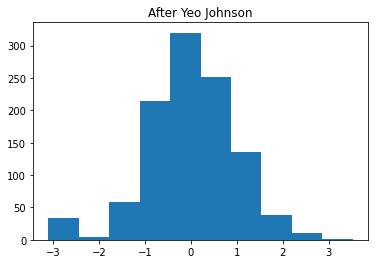

In [121]:
plt.hist(uncorr_updrs_1.iloc[:, 110])
plt.title('After Yeo Johnson')
plt.show()

In [122]:
sqrd_train_updrs_1 = uncorr_updrs_1.apply(lambda x: x**2)
sqrd_train_updrs_2 = uncorr_updrs_2.apply(lambda x: x**2)
sqrd_train_updrs_3 = uncorr_updrs_3.apply(lambda x: x**2)
sqrd_train_updrs_4 = uncorr_updrs_4.apply(lambda x: x**2)


In [123]:
def change_col_names(df, suffix):
    df.columns = [col+suffix for col in df.columns]
    return df

In [124]:
sqrd_train_updrs_1 = change_col_names(sqrd_train_updrs_1, '^2')
sqrd_train_updrs_2 = change_col_names(sqrd_train_updrs_2, '^2')
sqrd_train_updrs_3 = change_col_names(sqrd_train_updrs_3, '^2')
sqrd_train_updrs_4 = change_col_names(sqrd_train_updrs_4, '^2')

In [131]:
final_train_updrs_1 = pd.concat([uncorr_updrs_1, sqrd_train_updrs_1], axis=1)
final_train_updrs_2 = pd.concat([uncorr_updrs_2, sqrd_train_updrs_2], axis=1)
final_train_updrs_3 = pd.concat([uncorr_updrs_3, sqrd_train_updrs_3], axis=1)
final_train_updrs_4 = pd.concat([uncorr_updrs_4, sqrd_train_updrs_4], axis=1)

In [69]:
cat_updrs_1 = categorical_updrs_1[['patient_id', 'updrs_1_large_last_val', 'updrs_1_large_diff']]
cat_updrs_2 = categorical_updrs_2[['patient_id', 'updrs_2_large_last_val', 'updrs_2_large_diff']]
cat_updrs_3 = categorical_updrs_3[['patient_id', 'updrs_3_large_last_val', 'updrs_3_large_diff']]
cat_updrs_4 = categorical_updrs_4[['patient_id', 'updrs_4_large_last_val', 'updrs_4_large_diff']]

In [70]:
cat_updrs_1.head()

,patient_id,updrs_1_large_last_val,updrs_1_large_diff
0,55,1,1
1,942,0,0
2,1517,1,1
3,1923,0,0
4,2660,0,0


In [141]:
full_train_updrs_1 = pd.concat([train_updrs_1[['visit_id', 'patient_id', 'visit_month', 'updrs_1']], final_train_updrs_1], axis=1)   
full_train_updrs_2 = pd.concat([train_updrs_2[['visit_id', 'patient_id', 'visit_month', 'updrs_2']], final_train_updrs_2], axis=1)   
full_train_updrs_3 = pd.concat([train_updrs_3[['visit_id', 'patient_id', 'visit_month', 'updrs_3']], final_train_updrs_3], axis=1)   
full_train_updrs_4 = pd.concat([train_updrs_4[['visit_id', 'patient_id', 'visit_month', 'updrs_4']], final_train_updrs_4], axis=1)   


In [154]:
# full_train_updrs_1.to_csv('full_train_updrs_1.csv')
# full_train_updrs_2.to_csv('full_train_updrs_2.csv')
# full_train_updrs_3.to_csv('full_train_updrs_3.csv')
# full_train_updrs_4.to_csv('full_train_updrs_4.csv')

## Import the Removed Correlated Features dataframe

In [8]:
full_train_updrs_1 = pd.read_csv('full_train_updrs_1.csv')
full_train_updrs_2 = pd.read_csv('full_train_updrs_2.csv')
full_train_updrs_3 = pd.read_csv('full_train_updrs_3.csv')
full_train_updrs_4 = pd.read_csv('full_train_updrs_4.csv')

In [9]:
full_train_updrs_1 = full_train_updrs_1.drop(columns=['Unnamed: 0'])
full_train_updrs_2 = full_train_updrs_2.drop(columns=['Unnamed: 0'])
full_train_updrs_3 = full_train_updrs_3.drop(columns=['Unnamed: 0'])
full_train_updrs_4 = full_train_updrs_4.drop(columns=['Unnamed: 0'])

In [10]:
file_path = "filtered_cols.txt"
col_list = []

with open(file_path, "r") as file:
    for line in file.readlines():
        col_list.append(line.strip())

#print(col_list)

['P04196', 'P08697', 'Q12841', 'AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K_Q08380', 'AAFTEC(UniMod_4)C(UniMod_4)QAADK_P02768', 'AANEVSSADVK_Q13449', 'AATGEC(UniMod_4)TATVGKR_P01042', 'AATVGSLAGQPLQER_P02649', 'AAVYHHFISDGVR_P01024', 'ADDKETC(UniMod_4)FAEEGKK_P02768', 'ADDKETC(UniMod_4)FAEEGK_P02768', 'ADLSGITGAR_P01011', 'ADSGEGDFLAEGGGVR_P02671', 'AEAQEAEDQQAR_Q9UHG2', 'AEFAEVSK_P02768', 'AELQC(UniMod_4)PQPAA_P01024', 'AESPEVC(UniMod_4)FNEESPK_P43652', 'AFPALTSLDLSDNPGLGER_P08571', 'AGC(UniMod_4)VAESTAVC(UniMod_4)R_Q9Y6R7', 'AGLAASLAGPHSIVGR_P08294', 'AGLLRPDYALLGHR_Q96PD5', 'AIGAVPLIQGEYMIPC(UniMod_4)EK_P07339', 'AIGYLNTGYQR_P01023', 'AIPVTQYLK_P43652', 'AKAYLEEEC(UniMod_4)PATLRK_P25311', 'AKWEMPFDPQDTHQSR_P01011', 'ALEQDLPVNIK_Q96KN2', 'ALFLETEQLK_Q13740', 'ALGISPFHEHAEVVFTANDSGPRR_P02766', 'ALGISPFHEHAEVVFTANDSGPR_P02766', 'ALMSPAGMLR_O75144', 'ALPGTPVASSQPR_O14498', 'ALQDQLVLVAAK_P01019', 'ALVQQMEQLR_P06727', 'ALYLQYTDETFR_P00450', 'ANAGKPKDPTFIPAPIQAK_P01019', 'ANRPFLVFIR_P

In [11]:
inverse_updrs_1_df = full_train_updrs_1[col_list].apply(lambda x: 1 / x)
inverse_updrs_2_df = full_train_updrs_2[col_list].apply(lambda x: 1 / x)
inverse_updrs_3_df = full_train_updrs_3[col_list].apply(lambda x: 1 / x)
inverse_updrs_4_df = full_train_updrs_4[col_list].apply(lambda x: 1 / x)

In [12]:
inverse_updrs_1_df.columns = [col + '_inverse' for col in inverse_updrs_1_df.columns]
inverse_updrs_2_df.columns = [col + '_inverse' for col in inverse_updrs_2_df.columns]
inverse_updrs_3_df.columns = [col + '_inverse' for col in inverse_updrs_3_df.columns]
inverse_updrs_4_df.columns = [col + '_inverse' for col in inverse_updrs_4_df.columns]

In [13]:
full_train_updrs_1 = pd.concat([full_train_updrs_1, inverse_updrs_1_df], axis=1)
full_train_updrs_2 = pd.concat([full_train_updrs_2, inverse_updrs_2_df], axis=1)
full_train_updrs_3 = pd.concat([full_train_updrs_3, inverse_updrs_3_df], axis=1)
full_train_updrs_4 = pd.concat([full_train_updrs_4, inverse_updrs_4_df], axis=1)

In [16]:
full_train_updrs_1.head()

,visit_id,patient_id,visit_month,updrs_1,P04196,P08697,Q12841,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K_Q08380,AAFTEC(UniMod_4)C(UniMod_4)QAADK_P02768,AANEVSSADVK_Q13449,...,YQC(UniMod_4)YC(UniMod_4)YGR_P02751inverse,YSLTYIYTGLSK_P25311inverse,YTTEIIK_P00736inverse,YVGGQEHFAHLLILR_P02763inverse,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738inverse,YVNKEIQNAVNGVK_P10909inverse,YWGVASFLQK_P02753inverse,YYC(UniMod_4)FQGNQFLR_P02790inverse,YYTYLIMNK_P01024inverse,YYWGGQYTWDMAK_P02675inverse
0,15009_6,15009,6,10.0,-0.838289,-1.390535,-0.199149,0.017177,-0.624328,0.949180,...,4.391870,5.586484,5.799333,19.133605,0.679721,-0.968016,-40.612091,27.671088,-2.870291,4.396179
1,34182_72,34182,72,7.0,0.133830,0.783361,-0.935283,0.326712,-0.860789,-0.071549,...,4.265360,0.918211,15006.370111,1.517325,-1.248719,-1.924688,-1.845657,-0.963919,-2.078332,1.274280
2,23175_48,23175,48,3.0,0.146624,-2.538778,-0.665408,0.021414,0.520576,0.075207,...,2.308398,5.565532,11.599810,1.403027,5.276800,3.344763,0.738449,-2.976861,-14.198559,2.068239
3,55256_12,55256,12,3.0,0.571327,-0.097486,1.342446,0.864702,1.093839,0.775311,...,1.066234,-6.116822,0.856510,1.382607,-5.814811,1.437938,0.586187,2.716748,3.478222,4.393599
4,64674_6,64674,6,11.0,0.641809,0.845223,-0.532433,-0.515697,-0.028149,-0.068890,...,16.705642,-1.097743,-1.272772,1.863910,2.105034,-0.592204,-2.302709,0.523603,1.101319,1.601957


## Feature Selection based on the UPDRS regression

In [82]:
X = full_train_updrs_1.drop(columns=['visit_id', 'patient_id', 'updrs_1'])
y = full_train_updrs_1[['updrs_1']]

cols = X.columns

rf = RandomForestRegressor()
rf.fit(X, np.ravel(y))
selector = SelectFromModel(rf, prefit=True)
X_reduced = selector.transform(X)

support = selector.get_support()
    
updrs_1_feats = [x for x, y in zip(cols, support) if y == True]

C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [85]:
with open('updrs_1_cols.txt', 'w') as file:
    for val in updrs_1_feats:
        file.write(str(val))
        file.write('\n')

In [86]:
X = full_train_updrs_2.drop(columns=['visit_id', 'patient_id', 'updrs_2'])
y = full_train_updrs_2[['updrs_2']]

cols = X.columns

rf = RandomForestRegressor()
rf.fit(X, np.ravel(y))
selector = SelectFromModel(rf, prefit=True)
X_reduced = selector.transform(X)

support = selector.get_support()
    
updrs_2_feats = [x for x, y in zip(cols, support) if y == True]

C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [87]:
with open('updrs_2_cols.txt', 'w') as file:
    for val in updrs_2_feats:
        file.write(str(val))
        file.write('\n')

In [88]:
X = full_train_updrs_3.drop(columns=['visit_id', 'patient_id', 'updrs_3'])
y = full_train_updrs_3[['updrs_3']]

cols = X.columns

rf = RandomForestRegressor()
rf.fit(X, np.ravel(y))
selector = SelectFromModel(rf, prefit=True)
X_reduced = selector.transform(X)

support = selector.get_support()
    
updrs_3_feats = [x for x, y in zip(cols, support) if y == True]

C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [89]:
with open('updrs_3_cols.txt', 'w') as file:
    for val in updrs_3_feats:
        file.write(str(val))
        file.write('\n')

In [90]:
X = full_train_updrs_4.drop(columns=['visit_id', 'patient_id', 'updrs_4'])
y = full_train_updrs_4[['updrs_4']]

cols = X.columns

rf = RandomForestRegressor()
rf.fit(X, np.ravel(y))
selector = SelectFromModel(rf, prefit=True)
X_reduced = selector.transform(X)

support = selector.get_support()
    
updrs_4_feats = [x for x, y in zip(cols, support) if y == True]

C:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [91]:
with open('updrs_4_cols.txt', 'w') as file:
    for val in updrs_4_feats:
        file.write(str(val))
        file.write('\n')

In [95]:
len(updrs_4_feats), len(updrs_3_feats), len(updrs_2_feats), len(updrs_feats)

(604, 713, 685, 713)

In [143]:
updrs_4_feats

['visit_month',
 'Q12841',
 'AGLAASLAGPHSIVGR_P08294',
 'AGLLRPDYALLGHR_Q96PD5',
 'ALMSPAGMLR_O75144',
 'AQGFTEDTIVFLPQTDK_P41222',
 'AQTTVTC(UniMod_4)MENGWSPTPR_P08603',
 'AVLPTGDVIGDSAK_P01023',
 'AVSEKEVDSGNDIYGNPIKR_P16035',
 'C(UniMod_4)AEENC(UniMod_4)FIQK_P01024',
 'C(UniMod_4)C(UniMod_4)AAADPHEC(UniMod_4)YAK_P02768',
 'C(UniMod_4)FSGQC(UniMod_4)ISK_P10643',
 'C(UniMod_4)LAPLEGAR_P04217',
 'C(UniMod_4)LPVTAPENGK_P08603',
 'C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK_P02787',
 'C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK_P02749',
 'C(UniMod_4)STSSLLEAC(UniMod_4)TFR_P02787',
 'C(UniMod_4)TSTGWIPAPR_P08603',
 'DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK_P61916',
 'DC(UniMod_4)SLPYATESK_P23142',
 'DDNPNLPR_P02768',
 'DLGEENFK_P02768',
 'DQTVSDNELQEMSNQGSK_P10909',
 'DYFMPC(UniMod_4)PGR_P02790',
 'EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR_P24592',
 'EGVQKEDIPPADLSDQVPDTESETR_P01024',
 'ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYKK_P02774',
 'ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYK_P0277

In [14]:
# create a function for returning the best features
def feature_selection(train_updrs, cat_updrs, updrs='updrs_1'):
    
    # store the results
    feat_dict = dict()
    
    # get the min visit_month and the protein values for that month for each patient_id
    first_visit = train_updrs[['patient_id', 'visit_month']].groupby(['patient_id'])['visit_month'].min().reset_index()

    first_visit_updrs = first_visit.merge(train_updrs, how='left', left_on=['patient_id', 'visit_month'], right_on=['patient_id', 'visit_month'])
    feat_updrs_select = first_visit_updrs.merge(cat_updrs, how='left', left_on='patient_id', right_on='patient_id')
    
    # check the protein data vs the categorical labels
    y_change = feat_updrs_select[f'{updrs}_large_diff']
    X = feat_updrs_select.drop(columns=['visit_id', 'patient_id',f'{updrs}', 'visit_month', f'{updrs}_large_last_val', f'{updrs}_large_diff'])
    
    cols = X.columns
    
    # do feature selection using the random forest classifier
    model = RandomForestClassifier()
    sfm = SelectFromModel(estimator=model)
    X_transformed = sfm.fit_transform(X, y_change)
    
    support = sfm.get_support()
    
    updrs_feats = [x for x, y in zip(cols, support) if y == True]
    
    feat_dict[f'{updrs}_large_diff'] = updrs_feats
    
    # check the protein data vs the categorical labels
    y_last = feat_updrs_select[f'{updrs}_large_diff']
    X = feat_updrs_select.drop(columns=['visit_id', 'patient_id',f'{updrs}', 'visit_month', f'{updrs}_large_last_val', f'{updrs}_large_diff'])
    
    cols = X.columns
    
    # do feature selection using the random forest classifier
    model = RandomForestClassifier()
    sfm = SelectFromModel(estimator=model)
    X_transformed = sfm.fit_transform(X, y_last)
    
    support = sfm.get_support()
    
    updrs_feats = [x for x, y in zip(cols, support) if y == True]
    
    feat_dict[f'{updrs}_large_diff'] = updrs_feats
    
    return feat_dict, X, y_change, y_last

In [71]:
updrs_1_feats, X_updrs_1, updrs_1_change, updrs_1_last = feature_selection(full_train_updrs_1, cat_updrs_1, updrs='updrs_1')
updrs_2_feats, X_updrs_2, updrs_2_change, updrs_2_last = feature_selection(full_train_updrs_2, cat_updrs_2, updrs='updrs_2')
updrs_3_feats, X_updrs_3, updrs_3_change, updrs_3_last = feature_selection(full_train_updrs_3, cat_updrs_3, updrs='updrs_3')
updrs_4_feats, X_updrs_4, updrs_4_change, updrs_4_last = feature_selection(full_train_updrs_4, cat_updrs_4, updrs='updrs_4')

In [72]:
all_updrs_dict = {'updrs_1':[updrs_1_feats, X_updrs_1, updrs_1_change, updrs_1_last],
                 'updrs_2':[updrs_2_feats, X_updrs_2, updrs_2_change, updrs_2_last],
                 'updrs_3':[updrs_3_feats, X_updrs_3, updrs_3_change, updrs_3_last],
                  'updrs_4':[updrs_4_feats, X_updrs_4, updrs_4_change, updrs_4_last]}

In [73]:
len(all_updrs_dict['updrs_1'])

4

In [76]:
def test_feat_selection_change(all_updrs_dict, updrs='updrs_1'):
    print(f'\nResults for Change of {updrs} Category')
    updr_feats = all_updrs_dict[updrs][0][f'{updrs}_large_diff']
    X = all_updrs_dict[updrs][1]
    y = all_updrs_dict[updrs][2]
    
    X = X[updr_feats]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    X_train.shape, y_train.shape
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    roc_score = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
    
    preds = rf.predict(X_test)

    print(classification_report(y_test, preds))
    print(f'ROC AUC Score: {roc_score}')
    
#     print(f'\nResults for {updrs} Last Value Category')
#     updr_feats = all_updrs_dict[updrs][0][f'{updrs}_large_last_val']
#     X = all_updrs_dict[updrs][1]
#     y = all_updrs_dict[updrs][2]
    
#     X = X[updr_feats]

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#     X_train.shape, y_train.shape
#     rf = RandomForestClassifier()
#     rf.fit(X_train, y_train)

#     roc_score = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
    
#     preds = rf.predict(X_test)

#     print(classification_report(y_test, preds))
#     print(f'ROC AUC Score: {roc_score}\n')

In [77]:
for updr in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    test_feat_selection_change(all_updrs_dict, updrs=updr)


Results for Change of updrs_1 Category
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        33
           1       1.00      0.06      0.11        17

    accuracy                           0.68        50
   macro avg       0.84      0.53      0.46        50
weighted avg       0.78      0.68      0.57        50

ROC AUC Score: 0.746880570409982

Results for updrs_1 Last Value Category


KeyError: 'updrs_1_large_last_val'

#  Next Step Use these Categorical Features to Predict them on New Data
# -----------------------------------------------------------------------------------------------------------

## Use ML to impute the UPDRs 4 missing values

In [38]:
rf_imputer = RandomForestRegressor()


train_data = train_clin_df.dropna()

# drop the null value rows of updrs_1, 2, 3 since it is needed for imputing
to_impute_data = train_clin_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'])
to_impute_data = to_impute_data[to_impute_data['updrs_4'].isna()]

impute_trainer = train_data[train_data['updrs_4'].notnull()]

rf_imputer.fit(impute_trainer[['updrs_1', 'updrs_2', 'updrs_3']], impute_trainer[['updrs_4']])

impute_values = rf_imputer.predict(to_impute_data[['updrs_1', 'updrs_2', 'updrs_3']])

to_impute_data['updrs_4'] = [round(x) for x in impute_values]

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


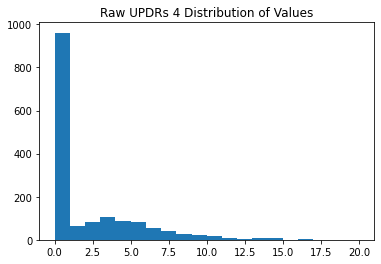

In [39]:
plt.hist(train_clin_df['updrs_4'], bins=20)
plt.title('Raw UPDRs 4 Distribution of Values')
plt.show()

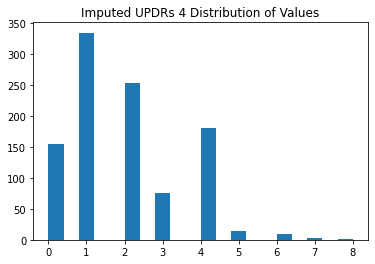

In [40]:
plt.hist(to_impute_data['updrs_4'], bins=20)
plt.title('Imputed UPDRs 4 Distribution of Values')
plt.show()

## Imputed UPDRs 4

The imputed values of UPDRs 4 are mostly between 0 and 2 but has far too many 1 values compared to the raw updrs. It may be better to look if there is a protein expressed that correlates highly with the non zero values.

In [41]:
# create a column with the UniProt and Peptide name combined
train_pep_df['peptide_uniprot'] = train_pep_df['Peptide'] + '_'+ train_pep_df['UniProt']
train_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,peptide_uniprot
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,NEQEQPLGQWHLS_O00391
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,GNPEPTFSWTK_O00533
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,IEIPSSVQQVPTIIK_O00533
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK_O00533
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,SMEQNGPGLEYR_O00533


In [42]:
# create a table with the visit_id as the index and the proteins or peptides as the feature and the abundance as the values
train_prot_pivot = train_prot_df.pivot(index='visit_id', values='NPX', columns='UniProt')
train_pep_pivot = train_pep_df.pivot(index='visit_id', values='PeptideAbundance', columns='peptide_uniprot')

In [43]:
# combine the two tables on the visit_id
full_prot_train_df = train_prot_pivot.join(train_pep_pivot)
full_prot_train_df = full_prot_train_df.reset_index(drop=True)
full_prot_train_df.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [44]:
# fill nan with 0 for this first round
full_prot_train_df = full_prot_train_df.fillna(0)

In [45]:
train_prot_pivot = train_prot_pivot.reset_index()

train_prot_pivot.head()

UniProt,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


In [46]:
train_prot_pivot = train_prot_pivot.fillna(0)

# merge the protein data and the clinical data
train_clin_prot = train_clin_df.merge(train_prot_pivot, on='visit_id', how='left')

In [47]:
train_clin_prot.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7
3,55_9,55,9,8.0,9.0,30.0,0.0,On,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,303953.0,43026.2,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9


In [48]:
# look for a correlation between the updrs_4 and the proteins
updrs_4_corr = train_clin_prot.corr()['updrs_4'].sort_values(ascending=False)
updrs_4_corr[:20]

updrs_4        1.000000
updrs_1        0.432620
updrs_2        0.383866
updrs_3        0.221593
visit_month    0.138013
P23083         0.124741
P31997         0.102361
P43251         0.089153
P16152         0.087579
P19827         0.082150
P01594         0.078567
P04275         0.076342
P55290         0.071613
P14314         0.071270
Q7Z5P9         0.062275
Q9UNU6         0.061301
Q6UX71         0.050691
O75144         0.050257
O94919         0.046582
O00391         0.045957
Name: updrs_4, dtype: float64

In [49]:
def imputer_updrs(val):
    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return np.nan

In [50]:
# can the updrs_4 be classified as 0 or greater than 0 
train_clin_prot['updrs_4_value_0'] = train_clin_prot['updrs_4'].apply(imputer_updrs)

In [51]:
# look for a correlation between the updrs_4_value_0 and the proteins
updrs_4_cat_corr = train_clin_prot.corr()['updrs_4_value_0'].sort_values(ascending=False)
updrs_4_cat_corr[:20]

updrs_4_value_0    1.000000
updrs_4            0.769702
updrs_1            0.336749
updrs_2            0.324829
visit_month        0.239479
updrs_3            0.219840
P43251             0.110328
P02655             0.077979
P19827             0.073717
P31997             0.071600
P04275             0.066442
P02765             0.065464
P11277             0.058547
P23083             0.054157
P55290             0.050317
Q7Z5P9             0.045373
P16152             0.039239
P04004             0.031860
Q9UNU6             0.030273
P02766             0.029575
Name: updrs_4_value_0, dtype: float64

In [52]:
# train a random forest classifier to predict the updrs_4_value_0
rf_clf = RandomForestClassifier()

# drop nan values for updrs_4
train_impute_prot = train_clin_prot.dropna(subset=['updrs_4', 'updrs_1', 'updrs_2', 'updrs_3'])
train_impute_prot = train_impute_prot.fillna(0)
train_impute_df  = train_impute_prot.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication'])
train_cols = train_impute_df.columns


# train the classifier
rf_clf.fit(train_impute_prot.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication']), train_impute_prot['updrs_4_value_0'])

RandomForestClassifier()

In [53]:
impute_df = train_clin_prot.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'])
impute_df = impute_df[impute_df['updrs_4'].isna()]

impute_X = impute_df.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication', 'updrs_4', 'updrs_4_value_0'])
fill_cols = [x for x in train_cols if x not in impute_X.columns]
fill_df = pd.DataFrame(columns=fill_cols)
impute_X = pd.concat([impute_X, fill_df], axis=1)
impute_X = impute_X.fillna(0)

impute_values = rf_clf.predict(impute_X[train_cols])

In [54]:
impute_df['updrs_4_pred'] = impute_values
impute_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_4_value_0,updrs_4_pred
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5,NaN,0.0
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7,NaN,0.0
13,942_0,942,0,3.0,2.0,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14,942_3,942,3,7.0,2.0,17.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [55]:
impute_df['updrs_4_pred'].value_counts()

0.0    1026
Name: updrs_4_pred, dtype: int64

## Imputer Results
Looks like all imputed values are 0 using the Random Forest

## Arange the Data from Different visit month predictions

Get the visit month 0 for each updrs since that will be the first prediction column target. And the protein data might come from visit_month 6 or 12 or 3, and still have to predict visit month 0 updrs.

In [133]:
month_0_cols = ['updrs_1_0_month' , 'updrs_2_0_month', 'updrs_3_0_month']

month_0_df = train_clin_df[train_clin_df['visit_month'] == 0][['patient_id','updrs_1', 'updrs_2', 'updrs_3']]

In [134]:
month_0_df.columns = ['patient_id'] + month_0_cols

train_clin_df = train_clin_df.merge(month_0_df, on='patient_id', how='left')

In [135]:
train_clin_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,10.0,6.0,15.0
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,10.0,6.0,15.0
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,10.0,6.0,15.0
3,55_9,55,9,8.0,9.0,30.0,0.0,On,10.0,6.0,15.0
4,55_12,55,12,10.0,10.0,41.0,0.0,On,10.0,6.0,15.0


In [136]:
# drop the updrs columns since this data will be used strictly for predicting visit 0
train_clin_df = train_clin_df.drop(columns=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'])

In [138]:
train_clin_df.head()

,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month
0,55_0,55,0,10.0,6.0,15.0
1,55_3,55,3,10.0,6.0,15.0
2,55_6,55,6,10.0,6.0,15.0
3,55_9,55,9,10.0,6.0,15.0
4,55_12,55,12,10.0,6.0,15.0


# ----------------------------------Restart Here-----------------------------------------

### Use the right join to eliminate any clinic visits that did not have the protein and peptides taken

### Try Random Forrest Regressor to start on updrs_1 only

target column will be updrs_1 and training data will be all the peptide and protein data.

visit_month, patient_id, and visit_month will all be excluded

#### Perform KFold Cross Validation on the Data for the Model

In [61]:
# randomize the rows
full_train_df = full_train_df.sample(frac=1).reset_index(drop=True)
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,21126_0,21126.0,0.0,10.0,2.0,13.0,12423.9,605605.0,46555.70,29230.4,...,204124.0,12742.40,3453650.0,90854.4,911147.0,103593.0,209362.0,503787.0,50218.7,NaN
1,2660_48,2660.0,48.0,2.0,0.0,0.0,0.0,771095.0,33814.90,47828.2,...,256010.0,12270.90,5021790.0,16990.9,108422.0,117118.0,133867.0,544726.0,48710.7,12826.3
2,58653_6,58653.0,6.0,6.0,3.0,15.0,0.0,378165.0,19136.70,19244.7,...,231229.0,5656.79,1599990.0,430472.0,3212740.0,75003.6,93197.7,490986.0,52954.5,41760.3
3,5036_60,5036.0,60.0,2.0,0.0,0.0,11818.2,474063.0,7748.81,25468.5,...,154162.0,10092.60,1761000.0,NaN,76096.0,101993.0,112469.0,NaN,NaN,28234.1
4,58648_60,58648.0,60.0,8.0,0.0,0.0,0.0,293805.0,25513.70,23002.7,...,252231.0,4555.03,4342770.0,30728.5,378719.0,53929.0,101590.0,392844.0,21614.9,23012.8


In [62]:
full_train_df.shape

(1113, 1201)

In [63]:
full_train_df['updrs_1_0_month'].isna().sum()

45

In [64]:
# calculate the number of bins by Sturge's rule
num_bins = int(np.floor(1 + np.log2(len(full_train_df))))
print(num_bins)

11


In [65]:
# bin the target updrs_1
full_train_df.loc[:, "bins"] = pd.cut(full_train_df['updrs_1_0_month'], bins=num_bins, labels=False)
full_train_df['bins'].head()

0    5.0
1    1.0
2    3.0
3    1.0
4    4.0
Name: bins, dtype: float64

In [66]:
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month,O00391,O00533,O00584,O14498,...,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675,bins
0,21126_0,21126.0,0.0,10.0,2.0,13.0,12423.9,605605.0,46555.70,29230.4,...,12742.40,3453650.0,90854.4,911147.0,103593.0,209362.0,503787.0,50218.7,NaN,5.0
1,2660_48,2660.0,48.0,2.0,0.0,0.0,0.0,771095.0,33814.90,47828.2,...,12270.90,5021790.0,16990.9,108422.0,117118.0,133867.0,544726.0,48710.7,12826.3,1.0
2,58653_6,58653.0,6.0,6.0,3.0,15.0,0.0,378165.0,19136.70,19244.7,...,5656.79,1599990.0,430472.0,3212740.0,75003.6,93197.7,490986.0,52954.5,41760.3,3.0
3,5036_60,5036.0,60.0,2.0,0.0,0.0,11818.2,474063.0,7748.81,25468.5,...,10092.60,1761000.0,NaN,76096.0,101993.0,112469.0,NaN,NaN,28234.1,1.0
4,58648_60,58648.0,60.0,8.0,0.0,0.0,0.0,293805.0,25513.70,23002.7,...,4555.03,4342770.0,30728.5,378719.0,53929.0,101590.0,392844.0,21614.9,23012.8,4.0


In [67]:
full_train_df = full_train_df.dropna(subset=['bins'])
full_train_df = full_train_df.reset_index()

In [68]:
# initiate the kfold class from sklearn
kf = StratifiedKFold(n_splits=5)

In [69]:
# create a kfold column
full_train_df['kfold'] = -1

# fill the kfold column
for f, (t_, v_) in enumerate(kf.split(X=full_train_df, y=full_train_df['bins'].values)):
    full_train_df.loc[v_, 'kfold'] = f

In [70]:
# drop the bins column
full_train_df = full_train_df.drop('bins', axis=1)


In [71]:
full_train_df.head()

,index,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month,O00391,O00533,O00584,...,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675,kfold
0,0,21126_0,21126.0,0.0,10.0,2.0,13.0,12423.9,605605.0,46555.70,...,12742.40,3453650.0,90854.4,911147.0,103593.0,209362.0,503787.0,50218.7,NaN,0
1,1,2660_48,2660.0,48.0,2.0,0.0,0.0,0.0,771095.0,33814.90,...,12270.90,5021790.0,16990.9,108422.0,117118.0,133867.0,544726.0,48710.7,12826.3,0
2,2,58653_6,58653.0,6.0,6.0,3.0,15.0,0.0,378165.0,19136.70,...,5656.79,1599990.0,430472.0,3212740.0,75003.6,93197.7,490986.0,52954.5,41760.3,0
3,3,5036_60,5036.0,60.0,2.0,0.0,0.0,11818.2,474063.0,7748.81,...,10092.60,1761000.0,NaN,76096.0,101993.0,112469.0,NaN,NaN,28234.1,0
4,4,58648_60,58648.0,60.0,8.0,0.0,0.0,0.0,293805.0,25513.70,...,4555.03,4342770.0,30728.5,378719.0,53929.0,101590.0,392844.0,21614.9,23012.8,0


In [72]:
full_train_df.shape

(1068, 1203)

In [73]:
train_csv_df = full_train_df.drop(columns=['kfold'])
train_csv_df.to_csv('../data/processed/train_data_visit0.csv', index=False)

In [156]:
updrs_1_cols = ['visit_id'] + updrs_feats
full_train_updrs_1[updrs_1_cols]
len(updrs_4_feats), len(updrs_3_feats), len(updrs_2_feats), len(updrs_feats)

(604, 713, 685, 713)

### ----------------------------------------- RESTART HERE ----------------------------------

In [164]:
updrs_feats

['visit_month',
 'P08697',
 'AESPEVC(UniMod_4)FNEESPK_P43652',
 'AGC(UniMod_4)VAESTAVC(UniMod_4)R_Q9Y6R7',
 'AGLAASLAGPHSIVGR_P08294',
 'AGLLRPDYALLGHR_Q96PD5',
 'AIGYLNTGYQR_P01023',
 'ALEQDLPVNIK_Q96KN2',
 'ALGISPFHEHAEVVFTANDSGPRR_P02766',
 'ALGISPFHEHAEVVFTANDSGPR_P02766',
 'ALMSPAGMLR_O75144',
 'APLIPMEHC(UniMod_4)TTR_P09486',
 'ASEGGFTATGQR_Q16610',
 'ASNLESGVPSR_P01594',
 'ASVGQDSPEPR_Q6UX71',
 'AVDTWSWGER_Q08380',
 'AVSEKEVDSGNDIYGNPIKR_P16035',
 'AVVFLEPQWYR_P08637',
 'C(UniMod_4)AEENC(UniMod_4)FIQK_P01024',
 'C(UniMod_4)KPVNTFVHEPLVDVQNVC(UniMod_4)FQEK_P07998',
 'C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK_P02787',
 'C(UniMod_4)RDQLPYIC(UniMod_4)QFGIV_P05452',
 'C(UniMod_4)REILSVDC(UniMod_4)STNNPSQAK_P10909',
 'C(UniMod_4)STSSLLEAC(UniMod_4)TFR_P02787',
 'C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK_P02749',
 'C(UniMod_4)YTAVVPLVYGGETK_P01591',
 'DASGVTFTWTPSSGK_P01876',
 'DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK_P61916',
 'DGGFC(UniMod_4)EVC(UniMod_4)K_P07602',
 'DKLAAC(UniM

In [216]:

# full_train_updrs_1.head()
updrs_1_feat_df = full_train_updrs_1[updrs_feats]
updrs_2_feat_df = full_train_updrs_2[updrs_2_feats]
updrs_3_feat_df = full_train_updrs_3[updrs_3_feats]
updrs_4_feat_df = full_train_updrs_4[updrs_4_feats]

# Insert KFOLDS here

In [278]:
updrs_1_kfolds.head()

,visit_id,patient_id,visit_month,updrs_1,O00391,O00533,O00584,O14498,O14773,O14791,...,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675,kfold
0,15009_6,15009,6,10.0,8405.07,534045.0,30143.1,20820.7,11807.80,0.00,...,8239.62,3261690.0,175652.00,1027150.0,61756.0,120733.0,471637.0,34750.8,13215.8,0
1,34182_72,34182,72,7.0,0.00,542513.0,19304.5,22916.5,6747.55,4420.99,...,7396.24,4937200.0,9970.55,73339.5,75484.3,98472.8,326149.0,32177.8,27313.8,0
2,23175_48,23175,48,3.0,11009.60,307536.0,16775.6,16795.3,10865.30,2884.05,...,7813.67,5102610.0,49680.00,346260.0,99610.6,182655.0,420676.0,40307.4,18854.4,0
3,55256_12,55256,12,3.0,10321.10,662077.0,40133.5,36077.4,38053.20,0.00,...,13707.10,5135370.0,30509.10,358032.0,112250.0,198959.0,517531.0,47780.1,13218.4,0
4,64674_6,64674,6,11.0,0.00,274549.0,21607.1,13334.7,15174.40,2240.71,...,3987.46,4570130.0,69358.80,407976.0,45884.6,103051.0,735200.0,61510.1,22546.5,0


In [279]:
updrs_1_feat_df = pd.concat([updrs_1_kfolds[['kfold', 'visit_id', 'patient_id','updrs_1', 'visit_month']], updrs_1_feat_df], axis=1)
updrs_2_feat_df = pd.concat([updrs_2_kfolds[['kfold', 'visit_id', 'patient_id','updrs_2', 'visit_month']], updrs_2_feat_df], axis=1)
updrs_3_feat_df = pd.concat([updrs_3_kfolds[['kfold', 'visit_id', 'patient_id','updrs_3', 'visit_month']], updrs_3_feat_df], axis=1)
updrs_4_feat_df = pd.concat([updrs_4_kfolds[['kfold', 'visit_id', 'patient_id','updrs_4', 'visit_month']], updrs_4_feat_df], axis=1)


In [280]:
def calculate_smape(y_true, y_pred):
    try:
        smape =  round(np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100, 2)
        return smape
    except:
        return 200

In [321]:
def rf_cv_model(df, target):
    
    final_smape = list()
    
    df = df.fillna(0)
    
    for fold in df['kfold'].unique():
        #print(f'Target: {target}')
        #print(f'Fold: {fold}')
        kfold = fold
        

        val_df = df[df['kfold'] == kfold].reset_index(drop=True)
        train_df = df[df['kfold'] != kfold].reset_index(drop=True)
        
        updr_list = [target]
        drop_list = ['visit_id', 'patient_id'] + updr_list
    
        y_train = train_df[[target]]
        X_train = train_df.drop(drop_list, axis=1)
        y_val = val_df[[target]]
        X_val = val_df.drop(drop_list, axis=1)

        rf = RandomForestRegressor(n_estimators=100,  random_state=25)

        rf.fit(X_train.values, y_train.values.ravel()) 

        val_preds = rf.predict(X_val.values)
        smape = calculate_smape(y_val.values.ravel(), val_preds)
        r2 = r2_score(y_val.values.ravel(), val_preds)
        
        #print(f'SMAPE: {smape}')
        #print(f'R-squared: {r2}\n')
        
        final_smape.append(smape)
        
    # print('Average SMAPE:', np.mean(final_smape))
    
    return np.mean(final_smape)

In [319]:
def stepwise_feat_add(df, cols, top_ten, target):
    
    # List to store the selected features
    selected_features = top_ten
    
    # Initialize the baseline performance
    best_error = np.inf
    
    count = 0
    feat_list = [col for col in cols if col not in top_ten]
    
    # Perform feature addition iteratively
    for col in feat_list:
        

        print(f'\nTesting {col}')
        print(100 * count / len(feat_list))
        if len(selected_features) == 0:
            # Combine the selected features and the current feature
            feature_set = ['kfold', 'visit_id', 'patient_id', target] + [col]
        else:
            # Combine the selected features and the current feature
            feature_set = selected_features + ['kfold', 'visit_id', 'patient_id', target] + [col]
        try:    
            # drop any duplicate columns
            test_df = df.loc[:,~df.columns.duplicated()].copy()
            # filter down to the features of interest
            test_df = test_df[feature_set]

            # Calculate the smape
            curr_smape = rf_cv_model(test_df, target)
            
            count += 1
            
            # Check if the current feature improves the performance
            if curr_smape < best_error:
                best_error = curr_smape
                
                # Add the best feature to the selected features
                selected_features.append(col)
                print('Keep', col)
                print('SMAPE', curr_smape)
                print('\n')
                
        
        except:
            print(f'Column {col} failed to process')
            count += 1
    
    return selected_features, best_error

In [297]:
def stepwise_feat_del(df, cols,  target):
    
    keep_cols = cols
    
    if 'visit_month' not in cols:
        cols = ['visit_month'] + cols
    
    
    for col in tqdm(cols):
        if len(keep_cols) > 1 and col in keep_cols and col != 'visit_month':
            print(f'Testing {col}')

            # drop any duplicate columns
            test_df = df.loc[:,~df.columns.duplicated()].copy()
            # filter down to the features of interest
            full_cols = keep_cols + ['kfold', 'visit_id', 'patient_id', target]
            full_col_df = test_df[full_cols]
            
            minus_col_df = full_col_df.drop(columns=[col])
            
            # generate the cv smape
            all_smape = rf_cv_model(full_col_df, target)
            minus_smape = rf_cv_model(minus_col_df, target)
        
            # find out if the smape is lower with the added feature
            if minus_smape < all_smape:
                keep_cols.remove(col)
            
                print('\n')
                print(f'Remove --- {col}') 
                print('Minus SMAPE:', minus_smape)
                print('All SMAPE:', all_smape)
                print('\n')
    
    return keep_cols, all_smape

In [312]:
def drop_duplicate_columns(df):
    df = df.loc[:,~df.columns.duplicated()].copy()
    return df

def write_list_to_file(lst, filename):
    with open(filename, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')
            
def write_dict_to_file(dic, filename, header):
    with open(filename, 'w') as file:
        file.write(str(header) + '\n')
        for k, v in dic.items():
            file.write(str(k) + ':' + str(v) + '\n')

In [313]:
def get_top_features(df, target_column, n=10):
    
    df = drop_duplicate_columns(df)
    
    # Separate the features and the target variable
    features = df.drop(target_column, axis=1)
    target = df[target_column]

    # Create and fit the random forest regression model
    rf = RandomForestRegressor()
    rf.fit(features, target)

    # Get feature importances
    importances = rf.feature_importances_

    # Create a DataFrame to store feature importances
    feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})

    # Sort the DataFrame by importance in descending order
    feature_importances = feature_importances.sort_values('Importance', ascending=False)

    # Return the top n features
    top_features = feature_importances.head(n)['Feature'].tolist()
    return top_features

In [317]:
# get top ten features for updrs_1
cols = ['visit_month'] + updrs_feats + ['updrs_1']
updrs_1_feat_df[cols]
updrs_1_top_ten = get_top_features(updrs_1_feat_df[cols], 'updrs_1')

# get top ten features for updrs_2
cols = ['visit_month'] + updrs_2_feats + ['updrs_2']
updrs_2_feat_df[cols]
updrs_2_top_ten = get_top_features(updrs_2_feat_df[cols], 'updrs_2')

# get top ten features for updrs_3
cols = ['visit_month'] + updrs_3_feats + ['updrs_3']
updrs_3_feat_df[cols]
updrs_3_top_ten = get_top_features(updrs_3_feat_df[cols], 'updrs_3')

# get top ten features for updrs_4
cols = ['visit_month'] + updrs_4_feats + ['updrs_4']
updrs_4_feat_df[cols]
updrs_4_top_ten = get_top_features(updrs_4_feat_df[cols], 'updrs_4')

In [318]:
updrs1_final_cols, min_smp_1 = stepwise_feat_add(updrs_1_feat_df, updrs_feats, updrs_1_top_ten, 'updrs_1')
print(min_smp_1)

write_list_to_file(updrs1_final_cols, 'updrs1_final_cols.txt')


Testing visit_month
Keep visit_month
SMAPE 68.358



Testing AESPEVC(UniMod_4)FNEESPK_P43652

Testing AGLAASLAGPHSIVGR_P08294
Keep AGLAASLAGPHSIVGR_P08294
SMAPE 67.816



Testing AGLLRPDYALLGHR_Q96PD5

Testing AIGYLNTGYQR_P01023
Keep AIGYLNTGYQR_P01023
SMAPE 67.546



Testing ALEQDLPVNIK_Q96KN2
Keep ALEQDLPVNIK_Q96KN2
SMAPE 67.296



Testing ALGISPFHEHAEVVFTANDSGPRR_P02766

Testing ALGISPFHEHAEVVFTANDSGPR_P02766
Keep ALGISPFHEHAEVVFTANDSGPR_P02766
SMAPE 67.17999999999999



Testing ALMSPAGMLR_O75144
Keep ALMSPAGMLR_O75144
SMAPE 66.952



Testing ASEGGFTATGQR_Q16610

Testing ASNLESGVPSR_P01594
Keep ASNLESGVPSR_P01594
SMAPE 66.574



Testing ASVGQDSPEPR_Q6UX71
Keep ASVGQDSPEPR_Q6UX71
SMAPE 66.56200000000001



Testing AVDTWSWGER_Q08380
Keep AVDTWSWGER_Q08380
SMAPE 66.44200000000001



Testing AVSEKEVDSGNDIYGNPIKR_P16035
Keep AVSEKEVDSGNDIYGNPIKR_P16035
SMAPE 66.046



Testing AVVFLEPQWYR_P08637

Testing C(UniMod_4)AEENC(UniMod_4)FIQK_P01024
Keep C(UniMod_4)AEENC(UniMod_4)FIQK_P01024
SMA


Testing VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANR_P06396

Testing VLNQELR_P05090

Testing VPEARPNSMVVEHPEFLK_P06396

Testing VSEADIQR_P05408

Testing VTEIWQEVMQR_P08294
Keep VTEIWQEVMQR_P08294
SMAPE 63.476



Testing VTGVVLFR_P08294

Testing VTIKPAPETEKRPQDAK_P01024

Testing VTIPTDLIASSGDIIK_Q14118

Testing VVEESELAR_P02748

Testing VYAC(UniMod_4)EVTHQGLSSPVTK_P01834
Keep VYAC(UniMod_4)EVTHQGLSSPVTK_P01834
SMAPE 63.458000000000006



Testing VYC(UniMod_4)DMNTENGGWTVIQNR_P02675

Testing WELALGR_P02649

Testing YFIDFVAR_P01042

Testing YHDRDVWKPEPC(UniMod_4)R_P02452

Testing YIFHNFMER_Q14624
Keep YIFHNFMER_Q14624
SMAPE 63.438



Testing YNSQNQSNNQFVLYR_P01042

Testing YWGVASFLQK_P02753

Testing P04196^2

Testing AANEVSSADVK_Q13449^2

Testing ADDKETC(UniMod_4)FAEEGKK_P02768^2

Testing ADDKETC(UniMod_4)FAEEGK_P02768^2

Testing ADLSGITGAR_P01011^2

Testing AEAQEAEDQQAR_Q9UHG2^2

Testing AEFAEVSK_P02768^2

Testing AESPEVC(UniMod_4)FNEESPK_P43652^2
Keep AESPEVC(UniMod_4)FNEESPK_P43652^2
SMAPE 6


Testing SGIEC(UniMod_4)QLWR_P00734^2

Testing SGLSTGWTQLSK_P04217^2

Testing SGNIPAGTTVDTK_Q9UKV8^2

Testing SGSAHEYSSSPDDAIFQSLAR_P16870^2

Testing SIVVSPILIPENQR_P55290^2

Testing SLAAAAGKQELAK_P61278^2

Testing SLEDLQLTHNKITK_P51884^2

Testing SLNNQIETLLTPEGSR_P08123^2

Testing SRYPVC(UniMod_4)GSDGTTYPSGC(UniMod_4)QLR_Q16270^2

Testing SSGQWQTPGATR_P06681^2

Testing SSNTYTLTDVRR_Q13740^2

Testing SSPVVIDASTAIDAPSNLR_P02751^2

Testing STTPDITGYR_P02751^2

Testing SVIPSDGPSVAC(UniMod_4)VKK_P02787^2

Testing TAKDALSSVQESQVAQQAR_P02656^2

Testing TASDFITK_P06396^2

Testing TC(UniMod_4)VADESAENC(UniMod_4)DKSLHTLFGDK_P02768^2

Testing TGAQELLR_P06396^2

Testing THLGEALAPLSK_O15240^2

Testing THLPEVFLSK_P02774^2

Testing TKEEYGHSEVVEYYC(UniMod_4)NPR_P08603^2

Testing TKKQELSEAEQATR_P01024^2

Testing TLKIENVSYQDKGNYR_O00533^2

Testing TLLSNLEEAK_P10909^2

Testing TLYSSSPR_P05155^2

Testing TMLLQPAGSLGSYSYR_P41222^2

Testing TMSEVGGSVEDLIAK_P07339^2

Testing TPENYPNAGLTMNYC(UniMod_4)R_P0074


Testing LIADLGSTSITNLGFR_Q92520inverse

Testing LINDYVK_P01011inverse

Testing LLAGDHPIDLLLR_Q14515inverse

Testing LLC(UniMod_4)GLLAER_P14174inverse

Testing LLDSLPSDTR_P05155inverse

Testing LLEELVR_Q99683inverse

Testing LLIYDASNR_P04433inverse

Testing LLPAQLPAEKEVGPPLPQEAVPLQK_Q16610inverse

Testing LMVELHNLYR_Q6UXB8inverse

Testing LPYTASSGLMAPR_Q15904inverse

Testing LRENELTYYC(UniMod_4)C(UniMod_4)K_P13987inverse

Testing LSITGTYDLK_P01009inverse

Testing LSKELQAAQAR_P02649inverse

Testing LSPIYNLVPVK_P02748inverse

Testing LSSWVLLMK_P01009inverse

Testing LTPLYELVK_P10643inverse

Testing LVGGPM(UniMod_35)DASVEEEGVRR_P01034inverse

Testing LVMGIPTFGR_P36222inverse

Testing LYGSEAFATDFQDSAAAKK_P01011inverse

Testing M(UniMod_35)ASGAANVVGPK_Q92520inverse

Testing M(UniMod_35)ELERPGGNEITR_P02671inverse

Testing M(UniMod_35)YLGYEYVTAIR_P02787inverse

Testing MDYPKQTQVSVLPEGGETPLFK_P06396inverse

Testing MFTTAPDQVDKEDEDFQESNK_P00450inverse

Testing MPC(UniMod_4)AELVREPGC(UniMod_4)GC

In [320]:
updrs_2_feats = [col for col in updrs_2_feats if '^2' not in col]
updrs_2_feats = [col for col in updrs_2_feats if 'inverse' not in col]
updrs2_final_cols, min_smp_2 = stepwise_feat_add(updrs_2_feat_df, updrs_2_feats, updrs_2_top_ten,  'updrs_2')
print(min_smp_2)

write_list_to_file(updrs2_final_cols, 'updrs2_final_cols.txt')


Testing P04196
0.0
Keep P04196
SMAPE 92.54400000000001



Testing Q12841
0.4830917874396135
Keep Q12841
SMAPE 92.328



Testing AAFTEC(UniMod_4)C(UniMod_4)QAADK_P02768
0.966183574879227

Testing AAVYHHFISDGVR_P01024
1.4492753623188406

Testing ADDKETC(UniMod_4)FAEEGKK_P02768
1.932367149758454

Testing AESPEVC(UniMod_4)FNEESPK_P43652
2.4154589371980677
Keep AESPEVC(UniMod_4)FNEESPK_P43652
SMAPE 91.97999999999999



Testing AGC(UniMod_4)VAESTAVC(UniMod_4)R_Q9Y6R7
2.898550724637681
Keep AGC(UniMod_4)VAESTAVC(UniMod_4)R_Q9Y6R7
SMAPE 91.094



Testing AGLAASLAGPHSIVGR_P08294
3.3816425120772946
Keep AGLAASLAGPHSIVGR_P08294
SMAPE 90.84400000000001



Testing AGLLRPDYALLGHR_Q96PD5
3.864734299516908

Testing AIPVTQYLK_P43652
4.3478260869565215
Keep AIPVTQYLK_P43652
SMAPE 90.798



Testing AKWEMPFDPQDTHQSR_P01011
4.830917874396135

Testing ALEQDLPVNIK_Q96KN2
5.314009661835748

Testing ALGISPFHEHAEVVFTANDSGPR_P02766
5.797101449275362

Testing ALMSPAGMLR_O75144
6.280193236714976
Keep ALMSPAGMLR_O


Testing NLQPASEYTVSLVAIKGNQESPK_P02751
59.42028985507246

Testing NNEGTYYSPNYNPQSR_P00450
59.90338164251208

Testing NPDSSTTGPWC(UniMod_4)YTTDPTVR_P00734
60.38647342995169
Keep NPDSSTTGPWC(UniMod_4)YTTDPTVR_P00734
SMAPE 88.796



Testing NSKFEDC(UniMod_4)C(UniMod_4)QEK_P02774
60.869565217391305
Keep NSKFEDC(UniMod_4)C(UniMod_4)QEK_P02774
SMAPE 88.71200000000002



Testing NVDGVNYASITR_Q9UBR2
61.35265700483092

Testing NVVYTC(UniMod_4)NEGYSLIGNPVAR_P10643
61.83574879227053

Testing PPTSAHGNVAEGETKPDPDVTER_P02790
62.31884057971015

Testing QAPGQGLEWMGR_P23083
62.80193236714976

Testing QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR_P02748
63.28502415458937

Testing QEPERNEC(UniMod_4)FLQHKDDNPNLPR_P02768
63.768115942028984

Testing QHM(UniMod_35)DSDSSPSSSSTYC(UniMod_4)NQMMR_P07998
64.2512077294686

Testing QRQEELC(UniMod_4)LAR_P02753
64.73429951690821

Testing QTALVELVK_P02768
65.21739130434783

Testing QVVAGLNFR_P01042
65.70048309178743

Testing RELDESLQVAER_P10909
66

In [322]:
updrs_3_feats = [col for col in updrs_3_feats if '^2' not in col]
updrs_3_feats = [col for col in updrs_3_feats if 'inverse' not in col]
updrs3_final_cols, min_smp_3 = stepwise_feat_add(updrs_3_feat_df, updrs_3_feats, updrs_3_top_ten,  'updrs_3')
print(min_smp_3)

write_list_to_file(updrs3_final_cols, 'updrs3_final_cols.txt')


Testing visit_month
0.0
Keep visit_month
SMAPE 85.06199999999998



Testing P04196
0.42016806722689076
Keep P04196
SMAPE 85.028



Testing Q12841
0.8403361344537815
Keep Q12841
SMAPE 84.622



Testing AAFTEC(UniMod_4)C(UniMod_4)QAADK_P02768
1.2605042016806722
Keep AAFTEC(UniMod_4)C(UniMod_4)QAADK_P02768
SMAPE 84.612



Testing AATGEC(UniMod_4)TATVGKR_P01042
1.680672268907563

Testing ADDKETC(UniMod_4)FAEEGKK_P02768
2.100840336134454
Keep ADDKETC(UniMod_4)FAEEGKK_P02768
SMAPE 84.536



Testing ADSGEGDFLAEGGGVR_P02671
2.5210084033613445
Keep ADSGEGDFLAEGGGVR_P02671
SMAPE 84.332



Testing AESPEVC(UniMod_4)FNEESPK_P43652
2.9411764705882355

Testing AGC(UniMod_4)VAESTAVC(UniMod_4)R_Q9Y6R7
3.361344537815126

Testing AGLAASLAGPHSIVGR_P08294
3.7815126050420167

Testing ALMSPAGMLR_O75144
4.201680672268908
Keep ALMSPAGMLR_O75144
SMAPE 83.94



Testing ALQDQLVLVAAK_P01019
4.621848739495798
Keep ALQDQLVLVAAK_P01019
SMAPE 83.83



Testing ALVQQMEQLR_P06727
5.042016806722689

Testing ALYLQYTDETFR_


Testing KREEAPSLRPAPPPISGGGYR_P02675
50.0

Testing KVEQAVETEPEPELR_P02649
50.42016806722689
Keep KVEQAVETEPEPELR_P02649
SMAPE 81.112



Testing KVPQVSTPTLVEVSR_P02768
50.84033613445378

Testing KYFIDFVAR_P01042
51.260504201680675

Testing LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR_P18065
51.680672268907564

Testing LAC(UniMod_4)C(UniMod_4)VVGVC(UniMod_4)GPGLWER_P08294
52.10084033613445

Testing LALLVDTVGPR_Q9Y646
52.52100840336134

Testing LC(UniMod_4)TVATLR_P02768
52.94117647058823

Testing LDIDSPPITAR_P14618
53.36134453781513

Testing LEAGDHPVELLAR_P09486
53.78151260504202

Testing LEGEAC(UniMod_4)GVYTPR_P18065
54.20168067226891

Testing LFAC(UniMod_4)SNK_P06396
54.621848739495796

Testing LFDSDPITVTVPVEVSR_P10909
55.04201680672269

Testing LGMDGYR_P61626
55.46218487394958

Testing LGQSLDC(UniMod_4)NAEVYVVPWEK_P01042
55.88235294117647

Testing LIADLGSTSITNLGFR_Q92520
56.30252100840336

Testing LIVHNGYC(UniMod_4)DGR_P02753
56.72268907563025

Testing LLDSLPSDTR_P05155
57.142857142857146

Testi

In [ ]:
updrs_4_feats = [col for col in updrs_4_feats if '^2' not in col]
updrs_4_feats = [col for col in updrs_4_feats if 'inverse' not in col]
updrs4_final_cols, min_smp_4 = stepwise_feat_add(updrs_4_feat_df, updrs_4_feats, updrs_4_top_ten,  'updrs_4')
print(min_smp_4)

write_list_to_file(updrs4_final_cols, 'updrs4_final_cols.txt')

## Do Hyperparameter Optimization on the Model

In [ ]:
# Define the random forest objective function
def objective(params):
    # Create a Random Forest Regressor with the given hyperparameters
    model = RandomForestRegressor(**params)
    
    # Compute the SMAPE using cross-validation
    smape = make_scorer(smape_score, greater_is_better=False)
    scores = cross_val_score(model, X, y, cv=5, scoring=smape)
    
    # Return the negative mean SMAPE (as fmin minimizes the objective)
    return -np.mean(scores)


# Define the xgboost objective function
def xgb_objective(params):
    # Create an XGBoost Regressor with the given hyperparameters
    model = XGBRegressor(**params)
    
    # Compute the SMAPE using cross-validation
    smape = make_scorer(smape_score, greater_is_better=False)
    scores = cross_val_score(model, X, y, cv=5, scoring=smape)
    
    # Return the negative mean SMAPE (as fmin minimizes the objective)
    return -np.mean(scores)



# Define the SMAPE metric
def smape_score(y_true, y_pred):
    try:
        numerator = np.abs(y_true - y_pred)
        denominator = np.abs(y_true) + np.abs(y_pred)
        return 2.0 * np.mean(numerator / denominator)
    except:
        return 200
    

In [ ]:
X = updrs_1_feat_df[updrs1_final_cols]
X = drop_duplicate_columns(X)
updrs_1_y = updrs_1_feat_df['updrs_1']
y = updrs_1_y.iloc[:, 0]

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(120, 1200)),
    'max_depth': hp.choice('max_depth', range(1, 30)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 100)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 0.2, 0.3])
}

# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
updrs1_best = fmin(
                    fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials
                    )

# Print the best hyperparameters
print("Best hyperparameters:")
print(updrs1_best)
write_dict_to_file(updrs1_best, 'updrs1_rf_hyper.txt', 'updrs1_rf_hyper')

In [ ]:
X = updrs_2_feat_df[updrs2_final_cols]
X = drop_duplicate_columns(X)
updrs_2_y = updrs_2_feat_df['updrs_2']
y = updrs_2_y.iloc[:, 0]

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(120, 1200)),
    'max_depth': hp.choice('max_depth', range(1, 30)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 100)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 0.2, 0.3])
}

# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
updrs2_best = fmin(
                    fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials
                    )

# Print the best hyperparameters
print("Best hyperparameters:")
print(updrs2_best)
write_dict_to_file(updrs2_best, 'updrs2_rf_hyper.txt', 'updrs2_rf_hyper')

In [ ]:
X = updrs_3_feat_df[updrs3_final_cols]
X = drop_duplicate_columns(X)
updrs_3_y = updrs_3_feat_df['updrs_3']
y = updrs_3_y.iloc[:, 0]

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(120, 1200)),
    'max_depth': hp.choice('max_depth', range(1, 30)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 100)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 0.2, 0.3])
}

# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
updrs3_best = fmin(
                    fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials
                    )

# Print the best hyperparameters
print("Best hyperparameters:")
print(updrs3_best)
write_dict_to_file(updrs3_best, 'updrs3_rf_hyper.txt', 'updrs3_rf_hyper')

In [ ]:
X = updrs_4_feat_df[updrs4_final_cols]
X = drop_duplicate_columns(X)
updrs_4_y = updrs_4_feat_df['updrs_4']
y = updrs_4_y.iloc[:, 0]

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(120, 1200)),
    'max_depth': hp.choice('max_depth', range(1, 30)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 100)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 0.2, 0.3])
}

# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
updrs4_best = fmin(
                    fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=100,
                    trials=trials
                    )

# Print the best hyperparameters
print("Best hyperparameters:")
print(updrs4_best)
write_dict_to_file(updrs4_best, 'updrs4_rf_hyper.txt', 'updrs4_rf_hyper')

## Hyperparameter Opt For XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
X = updrs_1_feat_df[updrs1_final_cols]
X = drop_duplicate_columns(X)
updrs_1_y = updrs_1_feat_df['updrs_1']
y = updrs_1_y.iloc[:, 0]

space = {
    'eta': hp.uniform('eta', 0.01, 0.1),
    'min_child_weight': hp.uniform('min_child_weight', 1, 7),
    'max_depth': hp.choice('max_depth', range(3, 25)),
    'learning_rate': hp.uniform('learning_rate', 0.1, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
xgb1_best = fmin(
    fn=xgb_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:")
print(xgb1_best)
write_dict_to_file(xgb1_best, 'updrs1_xgb_hyper.txt', 'updrs1_rf_hyper')

In [ ]:
X = updrs_2_feat_df[updrs2_final_cols]
X = drop_duplicate_columns(X)
updrs_2_y = updrs_2_feat_df['updrs_2']
y = updrs_2_y.iloc[:, 0]



# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
xgb2_best = fmin(
    fn=xgb_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:")
print(xgb2_best)
write_dict_to_file(xgb2_best, 'updrs2_xgb_hyper.txt', 'updrs2_xgb_hyper')

In [ ]:
X = updrs_3_feat_df[updrs_3_feats]
X = drop_duplicate_columns(X)
updrs_3_y = updrs_3_feat_df['updrs_3']
y = updrs_3_y.iloc[:, 0]


# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
xgb3_best = fmin(
    fn=xgb_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:")
print(xgb3_best)
write_dict_to_file(xgb3_best, 'updrs3_xgb_hyper.txt', 'updrs3_xgb_hyper')

In [ ]:
X = updrs_4_feat_df[updrs4_final_cols]
X = drop_duplicate_columns(X)
updrs_4_y = updrs_4_feat_df['updrs_4']
y = updrs_4_y.iloc[:, 0]

# Initialize the Trials object
trials = Trials()

# Run the hyperparameter optimization using TPE algorithm
xgb4_best = fmin(
    fn=xgb_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:")
print(xgb4_best)
write_dict_to_file(xgb4_best, 'updrs4_xgb_hyper.txt', 'updrs4_xgb_hyper')

# --------------------------------------------------------------------------------

In [99]:
def rf_cv_model(df, target):
    
    final_smape = list()
    
    df = df.fillna(0)
    
    for fold in df['kfold'].unique():
        print(f'Target: {target}')
        print(f'Fold: {fold}')
        kfold = fold
        

        val_df = df[df['kfold'] == kfold].reset_index(drop=True)
        train_df = df[df['kfold'] != kfold].reset_index(drop=True)
        
        updr_list = ['updrs_1_0_month', 'updrs_2_0_month', 'updrs_3_0_month']
        drop_list = ['visit_id', 'patient_id'] + updr_list
    
        y_train = train_df[[target]]
        X_train = train_df.drop(drop_list, axis=1)
        y_val = val_df[[target]]
        X_val = val_df.drop(drop_list, axis=1)

        rf = RandomForestRegressor(random_state=25)

        rf.fit(X_train.values, y_train.values.ravel()) 

        val_preds = rf.predict(X_val.values)
        smape = calculate_smape(y_val.values.ravel(), val_preds)
        r2 = r2_score(y_val.values.ravel(), val_preds)
        
        print(f'SMAPE: {smape}')
        print(f'R-squared: {r2}\n')
        
        final_smape.append(smape)
        
    print('Average SMAPE:', np.mean(final_smape))

In [100]:
updr = 'updrs_1_0_month'
rf_cv_model(full_train_df, updr)

Target: updrs_1_0_month
Fold: 0
SMAPE: 66.02
R-squared: 0.26388561303399194

Target: updrs_1_0_month
Fold: 1
SMAPE: 64.92
R-squared: 0.30835052610151825

Target: updrs_1_0_month
Fold: 2
SMAPE: 68.11
R-squared: 0.25411870007142257

Target: updrs_1_0_month
Fold: 3
SMAPE: 63.92
R-squared: 0.38183538358600577

Target: updrs_1_0_month
Fold: 4
SMAPE: 66.26
R-squared: 0.37541736188094565

Average SMAPE: 65.846


In [101]:
updr = 'updrs_2_0_month'
rf_cv_model(full_train_df, updr)

Target: updrs_2_0_month
Fold: 0
SMAPE: 95.59
R-squared: 0.2615463550362749

Target: updrs_2_0_month
Fold: 1
SMAPE: 90.01
R-squared: 0.3107941752656981

Target: updrs_2_0_month
Fold: 2
SMAPE: 92.05
R-squared: 0.2928462094203932

Target: updrs_2_0_month
Fold: 3
SMAPE: 84.3
R-squared: 0.24785848547817413

Target: updrs_2_0_month
Fold: 4
SMAPE: 87.9
R-squared: 0.27949341010589945

Average SMAPE: 89.97


In [102]:
updr = 'updrs_3_0_month'
rf_cv_model(full_train_df, updr)

Target: updrs_3_0_month
Fold: 0
SMAPE: 80.98
R-squared: 0.33481719701327217

Target: updrs_3_0_month
Fold: 1
SMAPE: 77.98
R-squared: 0.3526000532639617

Target: updrs_3_0_month
Fold: 2
SMAPE: 81.05
R-squared: 0.2653554109020635

Target: updrs_3_0_month
Fold: 3
SMAPE: 70.4
R-squared: 0.3527280965401032

Target: updrs_3_0_month
Fold: 4
SMAPE: 72.93
R-squared: 0.3435621951047668

Average SMAPE: 76.66799999999999


### Try XGBoost Regressor

In [103]:

import xgboost

def xgboost_cv_model(df, target):

    final_smape = list()
    
    df = df.fillna(0)
    
    for fold in df['kfold'].unique():
        print(f'Target: {target}')
        print(f'Fold: {fold}')
        kfold = fold
        

        val_df = df[df['kfold'] == kfold].reset_index(drop=True)
        train_df = df[df['kfold'] != kfold].reset_index(drop=True)
        
        updr_list = ['updrs_1_0_month', 'updrs_2_0_month', 'updrs_3_0_month']
        drop_list = ['visit_id', 'patient_id'] + updr_list
    
        y_train = train_df[[target]]
        X_train = train_df.drop(drop_list, axis=1)
        y_val = val_df[[target]]
        X_val = val_df.drop(drop_list, axis=1)

        xgb = xgboost.XGBRegressor()

        xgb.fit(X_train.values, y_train.values.ravel()) 

        val_preds = xgb.predict(X_val.values)
        smape = calculate_smape(y_val.values.ravel(), val_preds)
    
        print(f'SMAPE: {smape}\n')
        
        final_smape.append(smape)
        
    print('Average SMAPE:', np.mean(final_smape))

In [104]:
updr = 'updrs_1_0_month'
xgboost_cv_model(full_train_df, updr)

Target: updrs_1_0_month
Fold: 0
SMAPE: 64.35

Target: updrs_1_0_month
Fold: 1
SMAPE: 62.64

Target: updrs_1_0_month
Fold: 2
SMAPE: 66.75

Target: updrs_1_0_month
Fold: 3
SMAPE: 60.52

Target: updrs_1_0_month
Fold: 4
SMAPE: 66.29

Average SMAPE: 64.11


In [105]:
updr = 'updrs_2_0_month'
xgboost_cv_model(full_train_df, updr)

Target: updrs_2_0_month
Fold: 0
SMAPE: 97.19

Target: updrs_2_0_month
Fold: 1
SMAPE: 86.52

Target: updrs_2_0_month
Fold: 2
SMAPE: 92.42

Target: updrs_2_0_month
Fold: 3
SMAPE: 84.39

Target: updrs_2_0_month
Fold: 4
SMAPE: 88.85

Average SMAPE: 89.874


In [106]:
updr = 'updrs_3_0_month'
xgboost_cv_model(full_train_df, updr)

Target: updrs_3_0_month
Fold: 0
SMAPE: 80.08

Target: updrs_3_0_month
Fold: 1
SMAPE: 77.89

Target: updrs_3_0_month
Fold: 2
SMAPE: 81.84

Target: updrs_3_0_month
Fold: 3
SMAPE: 70.2

Target: updrs_3_0_month
Fold: 4
SMAPE: 72.23

Average SMAPE: 76.44800000000001
